# 1. Auswahl von geeigneten Mietverträgen für das Maschinelle Lernen

Im ersten Schritt wird eine Auswahl an geeigneten Beispiel Mietverträgen getroffen. Dies is nötig, da die Qualität der eingescannten Mietverträge unterschiedlich ist. Dafür sind folgende Teilschritte nötig:
* Einlesen der Dateien mit dem richtigen Encoding
* Zählen von validen und invaliden Zeichen
* Bestimmen eines Grenzwertes für das Verhältnis aus "validen vs invaliden Zeichen" für "gute Mietverträge"

In [3]:
import io

def read_file_with_correct_encoding(path):
	""" Reads a file from <path> and assumes UTF-8 encoding. Returns a String. """
	return io.open(path, mode="r", encoding="utf-8").read()

In [4]:
from pathlib   import Path
from tqdm.auto import tqdm
from natsort   import os_sorted
import pandas as pd

def read_all_files_from_folder(directory):
	""" Reads all available files from a folder and stores the filename, and the content (=String) of each file in a Pandas DataFrame.
	    Files are sorted according to how a file explorer would sort them (e.g. by numerical values found in file names instead of sorting lexicographically).
	    This ensure that files are sorted "clr_MV1.pdf.txt", "clr_MV2.pdf.txt", ... instead of "clr_MV1.pdf.txt", "clr_MV10.pdf.txt" in the DataFrame.
	    Note: the conversion from the Path(...)-generator to a list is not optimal since it needs O(n) memory. But it should be OK for our use-case and gives a nice progress bar showing the total number of files.
	"""
	read_files           = pd.DataFrame(columns=['filename', 'raw_content'])
	sorted_list_of_files = os_sorted(list(Path(directory).glob('**/*')))
	for file_obj in tqdm(sorted_list_of_files, desc="Loading files"):
		new_row    = pd.DataFrame({'filename': [file_obj.name], 'raw_content': [read_file_with_correct_encoding(file_obj.absolute())]})
		read_files = pd.concat([read_files, new_row], ignore_index=True)
	
	return read_files

rental_contract_dataframe = read_all_files_from_folder("../data/original")

Loading files: 100%|██████████| 1000/1000 [00:02<00:00, 467.05it/s]


Nun definieren wir eine Liste an Zeichen, die wir in einem Mietvertrag erwarten würden. Alle anderen Zeichen werten wir (in seltenen Fällen fälschlicherweise) als OCR-Fehler. Aus dem Verhältnis von validen zu invaliden Zeichen schätzen wir ab, ob ein OCR Scan gut funktioniert hat. Das ist nur eine sehr grobe Abschätzung. OCR-Fehler wie "kanr" anstatt "kann", "Anderung" anstatt "Änderung", "Dabel" anstatt "Dabei" oder "berücksiöhtigt" anstatt "berücksichtigt" werden mit diesem einfachen Verfahren nicht erkannt. Weiterhin kann es vorkommen, dass maschinell geschriebener Text gut erkannt wird, handschriftliche Teile hingegen sehr schlecht (siehe z.B. "clr_MV20.pdf.txt").

In [5]:
import re

# The following characters are defined as valid for rental contracts. That means, we would expect them in rental contracts.
# - upper and lower (because of flag "re.IGNORECASE") alphabetic characters ("A-Z"), including German umlauts (äöüß).
# - digits ("0-9")
# - punctuation (".,;:\-"). We do not expect "?", and "!" in a rental contract. Those are likely OCR errors.
# - whitespaces ("\s")
# - parentheses ("\(\)")
# - characters special to rental contracts ("€§&_")
# - Note: one could consider "@" (for e-mail addresses) and "%" (for per-cent charges). But they are much more likely to be OCR errors.
REGEXP_VALID_CHARS = re.compile(r"[A-ZÄÖÜß0-9.,;:\-\s\(\)€§&_]", re.IGNORECASE)

def ratio_of_valid_characters(content):
	""" Computes the ratio between valid and non-valid characters in a String.
	    We could use this to identify files where the OCR did well (= high ratio of valid characters).
	"""
	valid_chars     = len(re.findall(REGEXP_VALID_CHARS, content))
	non_valid_chars = len(content) - valid_chars
	
	return valid_chars / (valid_chars + non_valid_chars)

Nun werden die Verhältnisse von "validen vs invaliden Zeichen" für alle 1000 eingescannten Mietverträge in einem Histogramm geplottet.
Weiterhin berechnen wir den Mittelwert, die Standardabweichung, den Median und den Interquartilsabstand (IQR) für die 1000 Verhältnisse.
Die visuelle Darstellung sowie die berechneten statistischen Werte können später genutzt werden, um einen geeigneten Threshold festzulegen.

mean   = 0.99245
std    = 0.03102
median = 0.99499
IQR    = 0.00435
threshold candidate 1: median - 1.5*iqr = 0.98846. Keeping 901 rental contracts for analysis.
threshold candidate 2: median - 3  *iqr = 0.98194. Keeping 957 rental contracts for analysis.
threshold candidate 3: mean   - 1  *std = 0.96143. Keeping 993 rental contracts for analysis.
threshold candidate 4: mean   - 3  *std = 0.89939. Keeping 997 rental contracts for analysis.


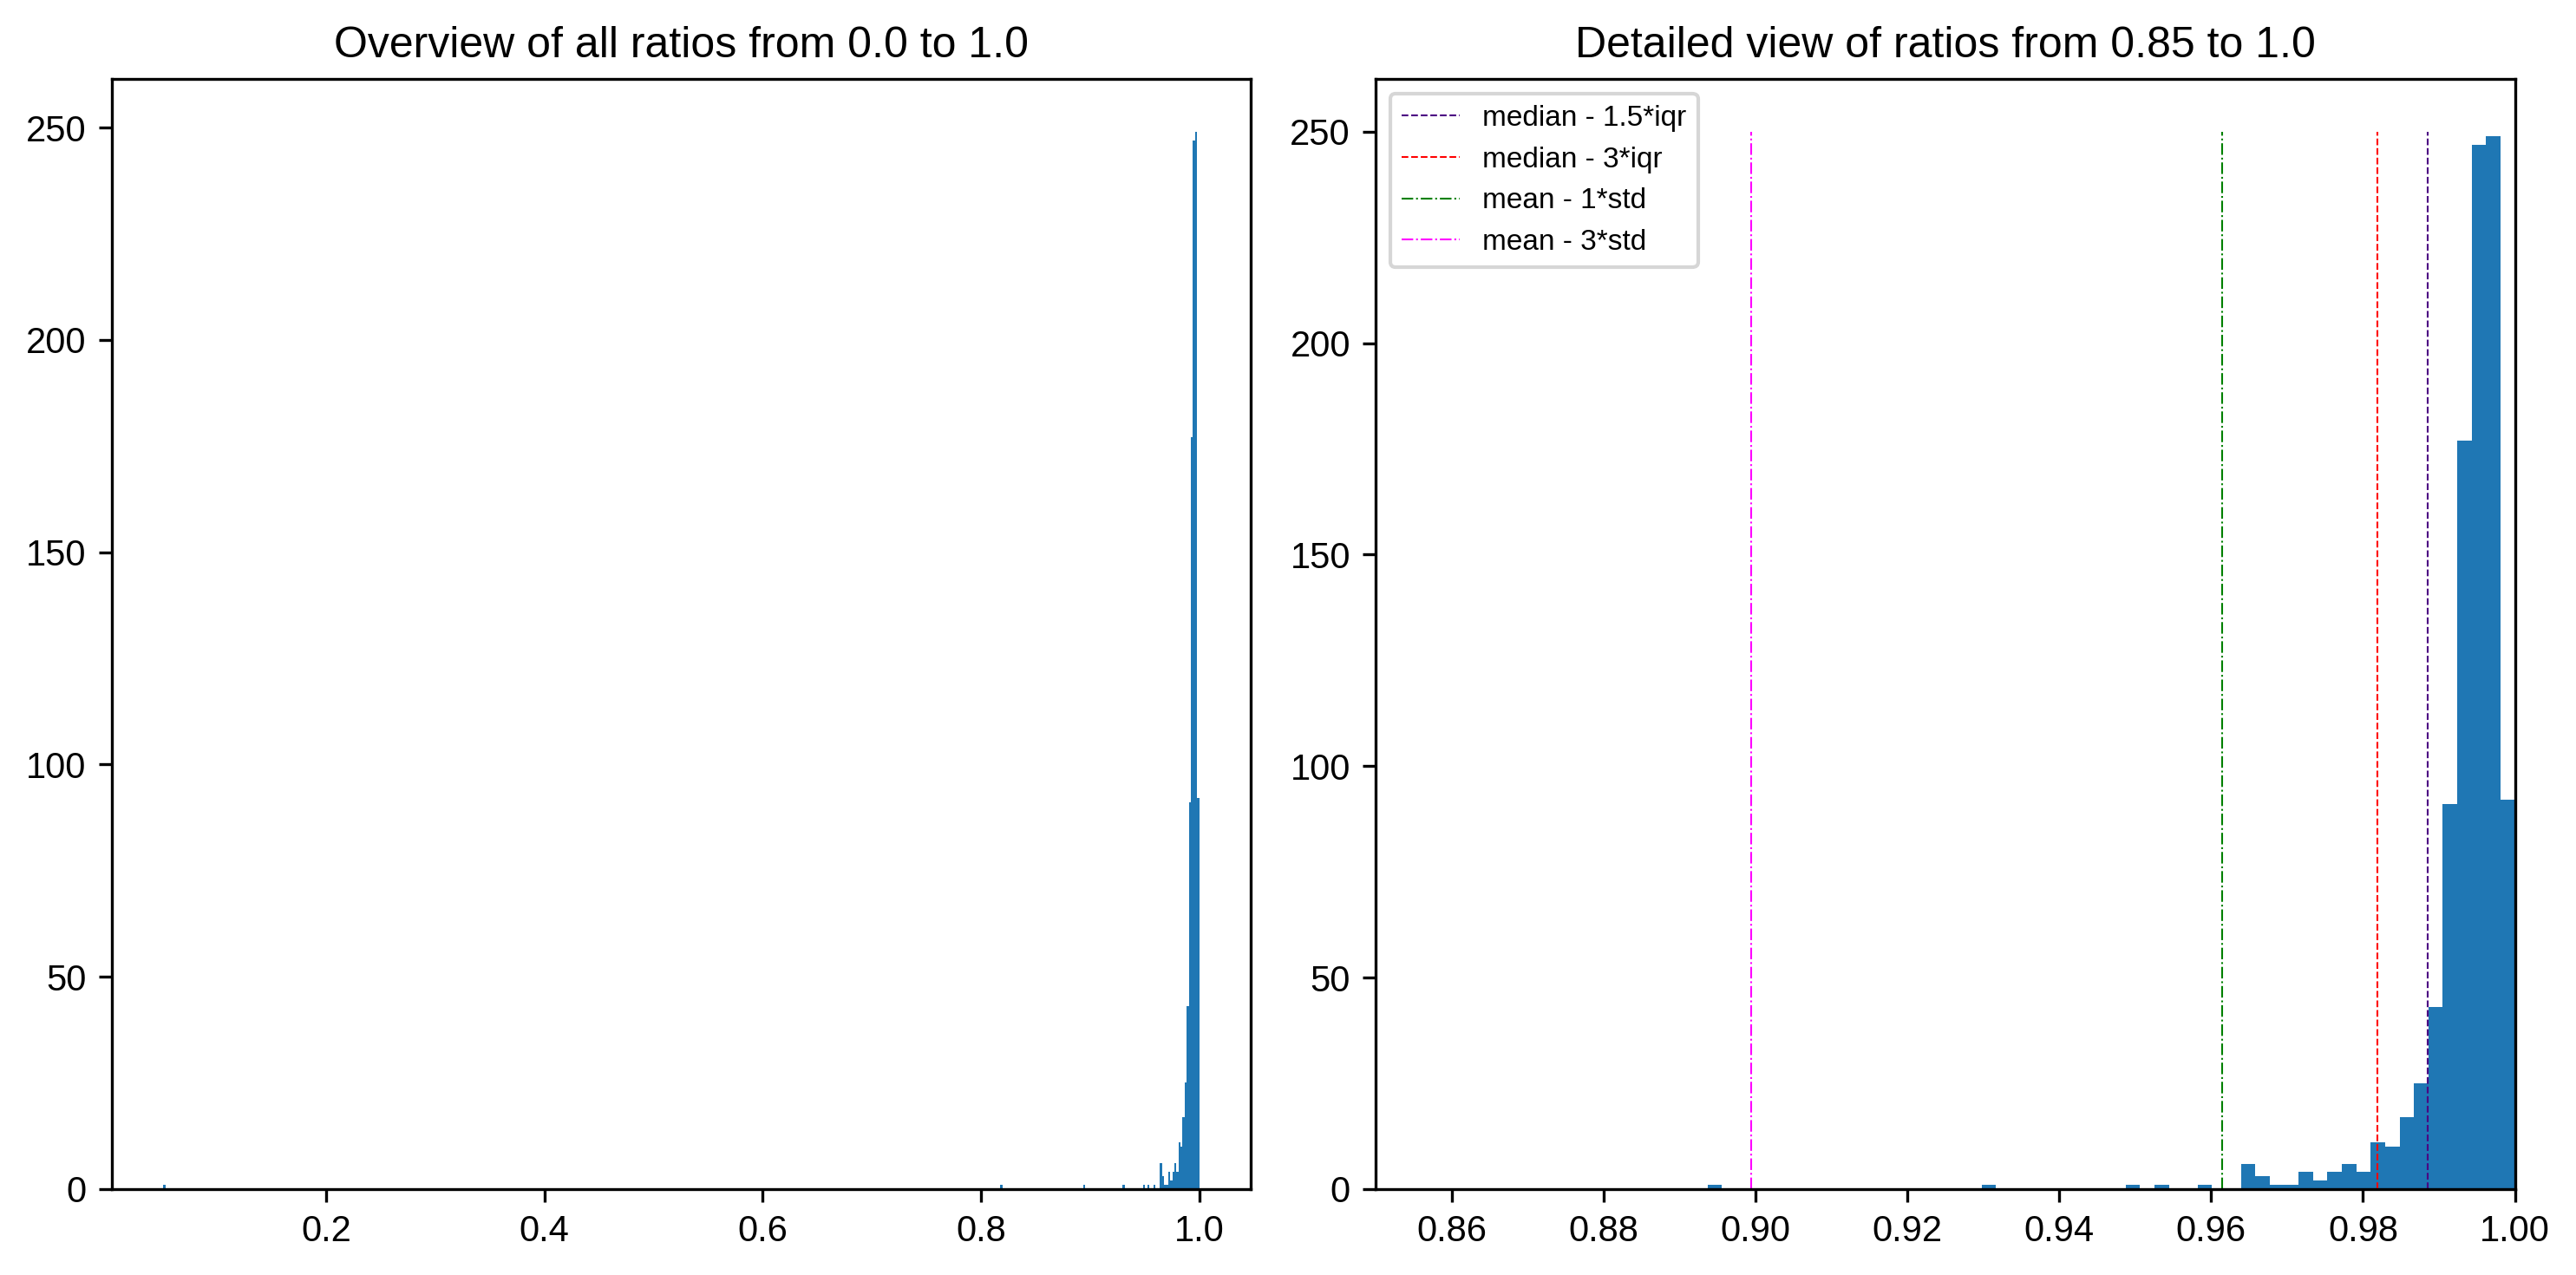

In [6]:
import matplotlib.pyplot as plt
import numpy             as np

# Calculate all ratios.
rental_contract_dataframe['valid_char_ratio'] = np.vectorize(ratio_of_valid_characters)(rental_contract_dataframe["raw_content"])

# Report statistics about all ratios.
mean     = round(np.mean(  rental_contract_dataframe['valid_char_ratio']), 5)
std      = round(np.std(   rental_contract_dataframe['valid_char_ratio']), 5)
median   = round(np.median(rental_contract_dataframe['valid_char_ratio']), 5)
q25, q75 = np.percentile(rental_contract_dataframe['valid_char_ratio'], [25, 75]) # Calculate 25% and 75% percentiles to calculate IQR = q75 - q25
iqr      = round(q75 - q25, 5)
print(f"mean   = {mean}")
print(f"std    = {std}")
print(f"median = {median}")
print(f"IQR    = {iqr}")
print(f"threshold candidate 1: median - 1.5*iqr = {round(median - 1.5*iqr, 5)}. Keeping {(rental_contract_dataframe['valid_char_ratio'] > median - 1.5*iqr).sum()} rental contracts for analysis.")
print(f"threshold candidate 2: median - 3  *iqr = {median - 3  *iqr          }. Keeping {(rental_contract_dataframe['valid_char_ratio'] > median - 3  *iqr).sum()} rental contracts for analysis.")
print(f"threshold candidate 3: mean   - 1  *std = {mean   - 1  *std          }. Keeping {(rental_contract_dataframe['valid_char_ratio'] > mean   - 1  *std).sum()} rental contracts for analysis.")
print(f"threshold candidate 4: mean   - 3  *std = {mean   - 3  *std          }. Keeping {(rental_contract_dataframe['valid_char_ratio'] > mean   - 3  *std).sum()} rental contracts for analysis.")

# Plot all ratios and a detailed view of very high ratios.
fig, (left_ax, right_ax) = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=300) # Create two plots beside each other.
left_ax.hist(rental_contract_dataframe['valid_char_ratio'], bins=500);             # In the first plot, show all ratios.
left_ax.set_title('Overview of all ratios from 0.0 to 1.0')

right_ax.hist(rental_contract_dataframe['valid_char_ratio'], bins=500);            # In the second plot, show the part with the "good" rental contracts to identify a threshold.
right_ax.set_xlim(0.85, 1.0)
right_ax.set_title('Detailed view of ratios from 0.85 to 1.0')

# Plot threshold candidates.
right_ax.vlines(median - 1.5*iqr, 0, 250, colors='indigo',  linestyles='--', linewidth=0.5, label="median - 1.5*iqr")
right_ax.vlines(median - 3  *iqr, 0, 250, colors='red',     linestyles='--', linewidth=0.5, label="median - 3*iqr")
right_ax.vlines(mean   - 1  *std, 0, 250, colors='green',   linestyles='-.', linewidth=0.5, label="mean - 1*std")
right_ax.vlines(mean   - 3  *std, 0, 250, colors='fuchsia', linestyles='-.', linewidth=0.5, label="mean - 3*std")
plt.legend(loc="upper left", prop={'size': 8})

# Style the plots.
plt.style.use('seaborn')  # Style the plots. You could use e.g. 'fivethirtyeight', 'seaborn', 'ggplot'. Run "plt.style.available" to see all available styles.
plt.tight_layout()        # Nicer tick placing.

Wir wählen einen Threshold von `median - 3*iqr` weil:
* Die Verteilung vermutlich keine Normalverteilung ist (da nach oben beschränkt).
  (Test mit Shapiro–Wilk wäre möglich.)
* Der Median robust gegen große Ausreißer ist.
* 3*IQR, da wir nur in eine Richtung testen (ansonsten wird oft 1.5 IQR gewählt, was ca. 2.7 std in einer Standardnormalverteilung entsprechen würde).

Hinweis: Dieser Threshold ist somit aber nur ein "educated guess", also nicht strikt mathematisch hergeleitet.

In [7]:
# Define the threshold according to an educated guess.
valid_non_valid_ratio_threshold = median - 3*iqr
# Also (manually) define rental contracts that should be kept or be rejected for Machine Learning in any case.
keep_list   = [f"clr_MV{number}.pdf.txt" for number in [2, 20, 131, 153, 274, 320, 345, 350, 413, 600, 828]]
reject_list = [f"clr_MV{number}.pdf.txt" for number in [69]]

def apply_treshold_and_reject_keep_lists(dataframe, threshold, keep_list, reject_list):
	# Select the rental contracts according to the defined threshold as well as to the keep- and reject-list.
	selected_dataframe = dataframe[((dataframe['valid_char_ratio'] > threshold) | dataframe['filename'].isin(keep_list)) & ~dataframe['filename'].isin(reject_list)]
	rejected_dataframe = dataframe[~dataframe['filename'].isin(selected_dataframe['filename'])]   # Reject all rows that should not be kept.
	
	return selected_dataframe, rejected_dataframe

selected_rental_contract_dataframe, rejected_rental_contract_dataframe = apply_treshold_and_reject_keep_lists(rental_contract_dataframe, valid_non_valid_ratio_threshold, keep_list, reject_list)

# Print the list of rejected rental contracts for manual inspection.
rejected_rental_contract_dataframe

filename                                        raw_content  \
25    clr_MV26.pdf.txt  \nN3LO943A ONNOLLTYATEIANSA ONN MONYAHIVN\n600...   
39    clr_MV40.pdf.txt  \nWLG\nMietvertrag für Wohnräume\n\nr\n\n \n\n...   
42    clr_MV43.pdf.txt  \nIN\n— Mietvertrag für Wohnräume\nzwischen Ve...   
62    clr_MV63.pdf.txt  \nZwischen ... ...     ...   „ vertreten durch...   
65    clr_MV66.pdf.txt  \n*— — — Hier in den Vertrag einfügen —— —\n\n...   
68    clr_MV69.pdf.txt  \n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\nFr...   
117  clr_MV118.pdf.txt  \nGAIEO\n.\nMietvertrag für Wohnräume\n\n \n\n...   
118  clr_MV119.pdf.txt  \nGAIEO\n.\nMietvertrag für Wohnräume\n\n \n\n...   
127  clr_MV128.pdf.txt  \nEdlellru cl G M AHMN\n\n)5zrm_5éadf, 7617220...   
142  clr_MV143.pdf.txt  \n,———""'——c—__..‚__\n\nA\ng Anlag%% 2‚\n\nL O...   
156  clr_MV157.pdf.txt  \nUE C &</<?ﬁ’xﬂ”\nU P}\n\nMietvertrag\n\nZwis...   
178  clr_MV179.pdf.txt  \n \n\nT M a E a n NDU, Y\n"U2|ININZSNE PUN U2...   
179  clr_MV180.pdf.txt  \n \n\nü\n\nU8PI8M MEqUI8I8N YINE UUEX (SIUNEW...   
198  clr_MV199.pdf.txt  \n]\n\nmöonatlich € 62.00 (1 W.:\n\nz einzuzah...   
214  clr_MV215.pdf.txt  \n \n\nL}\n\nb)\n\nR\n\n \n  \n \n\n \n\n \n\n...   
271  clr_MV272.pdf.txt  \nVon: 006071969776 Seite: 3/3 Datum: 09.02.20...   
274  clr_MV275.pdf.txt  \nEinheitsmietvertrag für Wohnungen und Häuser...   
290  clr_MV291.pdf.txt  \nL UWE2 MVAAM Hia OR la\n\n \n\nVE ”\nAL Miet...   
291  clr_MV292.pdf.txt  \n(5u MU A.90.95\n\nu €/UA 0/]) / £y(\n\nzwisc...   
330  clr_MV331.pdf.txt  \nAL\n\n \n\n \n\n \n\nUJ8]e1A Uap ]6311q0o Su...   
378  clr_MV379.pdf.txt  \n \n\n\n\n\n \n\n18}911 SIE\n\nN3109833A XINY...   
394  clr_MV395.pdf.txt  \nIN - ö ®\nAL Mietvertrag für Wohnräume\n\nzw...   
434  clr_MV435.pdf.txt  \n \n\n \n\n \n\n\n\n\n \n\n \n\n \n\n\n\n\n \...   
485  clr_MV486.pdf.txt  \n5 81/04\n\n27/01/2817 08:58 062548813971 JAE...   
489  clr_MV490.pdf.txt  \n \n\nEr M ED LEL E Dn\n\nAB ME E . E HE T\n\...   
495  clr_MV496.pdf.txt  \nWohnungs-Mietvertrag\n\nDer (Die) Vermieter ...   
506  clr_MV507.pdf.txt  \n \n\n...   
559  clr_MV560.pdf.txt  \n\\n\n \n\ns nm Vertrag-Nr. __ a\nMietvertrag...   
581  clr_MV582.pdf.txt  \nAr ;\n\nertrag für Wohnräume\nz„(ß„‚{g'.\n\n...   
606  clr_MV607.pdf.txt  \nN310843A MINYGCHIVN\n\n7A70 IDDFSWID WI030A-...   
628  clr_MV629.pdf.txt  \nUntermietvertrag\n\n \n\nzwischen\n\n \n\nna...   
685  clr_MV686.pdf.txt  \n06-06-03 11:40 0615240613 MANFRED MARKUS ->0...   
767  clr_MV768.pdf.txt  \n[xanune TUY 207\n\n \n\n \n\n \n\n          ...   
774  clr_MV775.pdf.txt  \n///7"€ /h‘i//7/c27\n\n2ischen Vermiekan? e (...   
780  clr_MV781.pdf.txt  \nMietvertrag für Wohnräume / ‘i$;(°%‘ e\n\nVe...   
789  clr_MV790.pdf.txt  \nWaohnunags-Nr - é\n\nWohnungs-Mietvertra:\n\...   
896  clr_MV897.pdf.txt  \n_Strﬂeund ...      ...       :\n\n/ ...  und...   
897  clr_MV898.pdf.txt  \n/\nur\n»‘=_‚==-\n‘ Vermietet: Qj\n\n \n\n1, ...   
900  clr_MV901.pdf.txt  \nMietvertrag für eine möblierte Wohnung\n\nVe...   
943  clr_MV944.pdf.txt  \nMN 4\n[ Mietvertrag für Wohnräume 7 44779 /\...   
957  clr_MV958.pdf.txt  \nMietvertrag für Wohnräume ='El/i Haus & Grun...   
959  clr_MV960.pdf.txt  \nP<\n\nZ - ® N\nAL Mietvertrag für Wohnräume\...   
977  clr_MV978.pdf.txt  \n='ä | -Mqueﬂräg für Wohnräume\n\nzwischen Ve...   
987  clr_MV988.pdf.txt  \nHV A, X07\n\nSeite 1 MV 2002\nWohnungs-Nr.10...   

     valid_char_ratio  
25           0.964065  
39           0.979007  
42           0.981661  
62           0.954317  
65           0.979104  
68           1.000000  
117          0.973235  
118          0.973235  
127          0.964975  
142          0.930189  
156          0.969502  
178          0.965390  
179          0.966898  
198          0.980769  
214          0.971277  
271          0.974965  
274          0.959712  
290          0.977897  
291          0.972136  
330          0.964363  
378          0.949268  
394          0.97608

# 2. Separiere Mietverträge in ihre Hauptüberschriften und Paragraphen

Zuerst initialisieren wir spaCy, eine NLP Bibliothek.
Dazu laden wir zwei vortrainierte Modelle für die Deutsche Sprache herunter:
* ein für CPU optimiertes (schnelles), ungenaueres Modell   (`de_core_news_lg`, https://spacy.io/models/de#de_core_news_lg)
	* Dieses Modell beinhaltet auch Wort-Embeddings (word-vectors).
	* Dieses Modell ist für eine einfache Tokenisierung, wie wir es bei der Überschriften-Extraktion anwenden, vollkommen ausreichend.
* ein für GPU optimiertes (langsameres), akkurateres Modell (`de_dep_news_trf`, https://spacy.io/models/de#de_dep_news_trf)
	* Dieses Modell basiert auf Transformern (BERT)
	* Dieses Modell kann später für eine (leicht) genauere Analyse zum Einsatz kommen.
	* Dieses Modell kann mittels Transfer-Learning an "Mietverträge" angepasst werden.

In [8]:
# Set up spaCy for German language by downloading two German language model.
# Note: Un-comment the lines below to download the data once. Then, comment these lines again to save time during Jupyter Notebook execution.

# The first model is fast, but not so accurate. See https://spacy.io/models/de#de_core_news_sm.
# !python -m spacy download de_core_news_lg

# The first model is fast, but not so accurate. See https://spacy.io/models/de#de_dep_news_trf.
# !python -m spacy download de_dep_news_trf

import spacy

nlp_fast     = spacy.load("de_core_news_lg")
nlp_accurate = spacy.load("de_dep_news_trf")

Wir definieren eine Methode, um die Mietverträge in ihre Paragraphen aufzuteilen.
Das hilft uns später, die Machine Learning Verfahren auf bestimmte (semantische) Teilbereiche des Mietvertrags, anzuwenden.

In [9]:
def find_headlines(content, nlp):
	""" Find the main headlines in rental contracts.
		We make the assumption that a headline is in its own line. That means, it is not included in any running text. 
		That means, we can split the text into lines and check for each line, if it is a headline.

		Returns a list of [Headline_String, Line_Index, Score]
	"""

	# - We assume that a headline starts with either one or more:
	#   - § (real paragraph symbol)
	#   - 8 (OCR version of §) 
	#   - $ (OCR version of §)
	#   - S (OCR version of §)
	#   - 5 (OCR version of §)
	#   - & (OCR version of §)
	# - followed by optional whitespaces
	# - followed by a number
	RE_STARTS_WITH_SYMBOL_AND_NUMBER = re.compile(r"^([§8$S5&]+)(\s*)(\d+)", re.IGNORECASE) # (\s*?)(\D*?)
	RE_START_WITH_NR                 = re.compile(r"^(Nr\.)(\s*)(\d+)")
	RE_START_WITH_DOTS               = re.compile(r"^\.{3}\s\.{3}")        

	INVALID_SYMBOLS = [">", "<", ":", "[", "]", "{", "}"] # "\u201a", "|",  ";", "'", "´",
	INVALID_GRAMMA  = ["VERB", "AUX", "ADV"]

	found_headlines = []

	for line_idx, line in enumerate(content.splitlines()):
		score = 0
		RE_START = []
		
		OBJ_STARTS_WITH_SYMBOL_AND_NUMBER = re.search(RE_STARTS_WITH_SYMBOL_AND_NUMBER, line.strip())
		OBJ_START_WITH_NR                 = re.search(RE_START_WITH_NR, line.strip())
		OBJ_START_WITH_DOTS               = re.search(RE_START_WITH_DOTS, line)
		
		# Add headlines that had been identified by humans beforehand by reading through the scanned rental contracts.
		if line in [
				"Mehrere Personen als Mieter", "Schriftformerfordernis",
				"Benutzung der Aufzugsanlagen", "Elektrizität, Gas, Wasser", "Bauliche Maßnahmen durch den Mieter", "Miete und Nebenkosten", "Zahlung der Miete und der Nebenkosten", # clr_MV345.pdf.txt
				"Instandhaltung der Mieträume", # clr_MV394.pdf.txt
				"Datenschutz", "Hausordnung",
				"Anlage", "Anlagen", "Anlage 1 des Mietvertrags", "Anlage zum Mietvertrag"
			]:
			score += 80
		
		# Add lines that starts with a (OCR'ed) "paragraph" symbol, followed by a number.
		if OBJ_STARTS_WITH_SYMBOL_AND_NUMBER:
			score += 80
			RE_START = OBJ_STARTS_WITH_SYMBOL_AND_NUMBER.span()

		# Add lines that starts with Nr. enumeration
		if OBJ_START_WITH_NR:
			score += 80
			RE_START = OBJ_START_WITH_NR.span()

		# Add lines that starts with specific pattern of dots
		if OBJ_START_WITH_DOTS:
			score += 80
			RE_START = OBJ_START_WITH_DOTS.span()

		# Optimization: only perform more thorough checks if we identified a potential headline before.
		if score >= 80:

			# Punish too short or too long lines (in terms of characters).
			if len(line.strip()) < 6 or len(line.strip()) > 90:
				score -= 21

			# Punish lines about BGB paragraphs (could start with a (OCR'ed) "paragraph" symbol followed by a number).
			if re.search(re.compile(r"bgb", flags=re.IGNORECASE), line.strip()):
				score -= 22

			# Punish lines that start with percent specifications (especially 50 % or 80 %, which will be found by RE_STARTS_WITH_SYMBOL_AND_NUMBER).
			if re.search(re.compile(r"^(5|8)\d+.+?\%", flags=re.IGNORECASE), line.strip()):
				score -= 23

			# Punish lines that have less letters than other characters.
			if len(re.findall(re.compile(r"[a-zÀ-ž\s]", flags=re.IGNORECASE), line.strip())) < len(re.findall(re.compile(r"[^a-zÀ-ž\s]", flags=re.IGNORECASE), line.strip())): 
				score -= 24

			# Punish lines that have less lower characters than upper characters.
			if len(re.findall(re.compile(r"[a-z]"), line.strip())) < len(re.findall(re.compile(r"[A-Z]"), line.strip())): 
				score -= 25

			# Punish lines with many tokens. Those are likely sentences from running text and not headlines.
			if len(nlp(line)) > 15:
				score -= 26
				# tmp_token = [token.pos_ for token in nlp(line)]
				# output = re.findall(r'NOUNPUNCT|NOUNCONJ|NOUNCCONJ', ''.join(tmp_token))
				# if len(output) > 2: pass
				# else: score -= 26

			# Punish lines with invalid symbols. Parentheses are often used in subparagraphs.
			if any((x in line) for x in INVALID_SYMBOLS):
				score -= 27

			# Punish lines with paranthesis of subparagraphs.
			if re.search(re.compile(r"(\(\w{1}\))|(\W\w{1}\))", flags=re.IGNORECASE), line.strip()):
				score -= 28

			# Punish lines with single/double character/s. Single/Double characters is/are not a word.
			if RE_START:
				RE_REST  = line[RE_START[1]:].strip()
				if re.search(r"\d+", RE_REST) or len(re.findall(re.compile(r"[a-zÀ-ž]", flags=re.IGNORECASE), RE_REST)) < 3:
					score -= 29

			# Punish lines with currency.
			if re.search(r"\d+,\d+", line.strip()):
				score -= 30

			# Punish lines with POS tagging of verb, auxiliary and adverb.
			if any((x in [token.pos_ for token in nlp(line)]) for x in INVALID_GRAMMA):
				if re.search("(soweit vorhanden)", line): pass
				else: score -= 31

		# Final threshold checking.
		if score >= 80:
			found_headlines.append([line, line_idx, score])

	return found_headlines

Extrahiere die Überschriften aus allen selektierten Mietverträgen.

In [10]:
# Retrieve headlines for all selected rental contracts. Takes around 4 minutes on Sascha's machine.
headlines_of_all_selected_files = {}
for index, row in tqdm(list(selected_rental_contract_dataframe.iterrows())):
	current_headlines                                = find_headlines(row['raw_content'], nlp_fast)
	headlines_of_all_selected_files[row['filename']] = current_headlines

headlines_of_all_selected_files

100%|██████████| 956/956 [19:09<00:00,  1.20s/it]


{'clr_MV1.pdf.txt': [['Nr. 1 Benutzung der Mietsache, der gemeinschaftlichen Anlagen und Einrichtungen',
   24,
   80],
  ['Nr. 2 Mietzahlung', 36, 80],
  ['Nr. 3 Übergabe der Mietsache', 45, 80],
  ['Nr. 4 Erhaltung der Mietsache', 52, 80],
  ['Nr. 5 Modernisierung und Energieeinsparung', 100, 80],
  ['Nr. 6 Zustimmungspflichtige Handlungen des Mieters', 107, 80],
  ['Nr. 7 Besichtigung der Mietsache durch dem Vermieter', 160, 80],
  ['Nr. 8 Fristlose Kündigung', 168, 80],
  ['Nr. 9 Keine stillschweigende Verlängerung', 197, 80],
  ['Nr. 10 Beendigung des Mietverhältnisses durch Tod', 203, 80],
  ['Nr. 11 Rückgabe der Mietsache', 222, 80],
  ['Nr. 12 Personenmehrheit der Mieter', 259, 80],
  ['Nr. 13 Schlussbestimmungen', 267, 80],
  ['8 1 Mietsache', 300, 80],
  ['S 2 Miete und Nebenleistungen', 387, 80],
  ['Hausordnung', 548, 80],
  ['8 3 Zusätzliche Vereinbarungen', 567, 80],
  ['... ... Mietdauer', 590, 80],
  ['S 5 Aushändigung der Vertragsunterlagen', 610, 80],
  ['... ... Ände

In [11]:
# Create pandas dataframe.
def get_first(ll) : return ll[0]
def get_second(ll): return ll[1]
def get_pars(ll)  : return list(map(get_first,ll))
def get_pos(ll)   : return list(map(get_second,ll))

pars = list(map( get_pars, list(headlines_of_all_selected_files.values())))
pos  = list(map( get_pos, list(headlines_of_all_selected_files.values())))

df = pd.DataFrame.from_dict({"filename": list(headlines_of_all_selected_files.keys()),
							"headlines": pars,
							"headlines_pos": pos
							})
df["#headlines"] = list(map(len, df["headlines"]))
df   = pd.merge(df, 
			  selected_rental_contract_dataframe[["filename", "raw_content"]], 
			  left_on="filename", right_on="filename")
cols = df.columns.tolist()
cols = cols[:1] + cols[-1:] + cols[1:-1:]
df   = df[cols]

Die Veträge werden nach einer validen Anzahl an Headlines gefiltert. Werden keine Headlines gefunden, so können keine Paragraphen identifiziert werden.

In [12]:
df.head()

filename                                        raw_content  \
0  clr_MV1.pdf.txt  \n#72DI7 ... ...  IW\n\n \n\nviterra\nZweitsch...   
1  clr_MV2.pdf.txt  \nMietvertrag für Wohnräume\n\nZwischen Vermie...   
2  clr_MV3.pdf.txt  \n  Seite 1 von 15 \n\n \n\nMietvertrag für Wo...   
3  clr_MV4.pdf.txt  \nsigel Art.-Nr. MV 480/MV 580\n\n \n\nRechnun...   
4  clr_MV5.pdf.txt  \nP\n\nS 4 3486\n\n \n\n/ £.\no PocHRe\n\nAM\n...   

                                           headlines  \
0  [Nr. 1 Benutzung der Mietsache, der gemeinscha...   
1  [8 1 Mieträume, $ 2 Mietzeit, $ 3 Außerordentl...   
2  [§ 1 Mieträume , § 2 Mietzeit , § 3 Teilkündig...   
3                                                 []   
4                                      [Hausordnung]   

                                       headlines_pos  #headlines  
0  [24, 36, 45, 52, 100, 107, 160, 168, 197, 203,...          22  
1  [10, 28, 46, 67, 182, 203, 219, 225, 295, 306,...          20  
2  [26, 49, 61, 86, 213, 309, 319, 360, 406, 420,...          24  
3                                                 []           0  
4                                              [637]           1

In [13]:
df_selected_files           = df[df["#headlines"]>0]
df_rejected_rental_contract = df[df["#headlines"]==0]
df_rejected_rental_contract.head()

filename                                        raw_content  \
3    clr_MV4.pdf.txt  \nsigel Art.-Nr. MV 480/MV 580\n\n \n\nRechnun...   
12  clr_MV13.pdf.txt  \n‚ützt - Nachahmung verboten\nag GmbH & Co KG...   
20  clr_MV21.pdf.txt  \nZwischen\nin\nvertreten durch\nund\nsowie\n\...   
31  clr_MV33.pdf.txt  \nsigel| Art.-Nr. MV 464\n\nET\n\nMietrechtsre...   
32  clr_MV34.pdf.txt  \nan CertiFORM\n\nÄ(0 RE 4a/ k\na AT HSR 6A3\n...   

   headlines headlines_pos  #headlines  
3         []            []           0  
12        []            []           0  
20        []            []           0  
31        []            []           0  
32        []            []           0

In der Funktion zur Extraktion von Paragraphen werden Paragraphen als ein Textabschnitt zwischen zwei Überschriften definiert. Die erste Position von Headlines ist in der Dataframe df_selected_files_valid_headlines unter der Spalte "headlines pos" notiert.

In [14]:
from itertools import chain

def find_paragraphs(content, line_pos):
	"""
	    Find paragraphs in rental contract.
	    
	    Input: content  : <string> raw content of rental contract.
	           line_pos : <list> list of line indices of founded headlines in the contract.
	    Output:    init : <string> head/preamble of rental contract.
	               pars : <list of strings> all paragraphs of rental contract. 
	"""
	
	content = content.splitlines()
	init    = [] 
	pars    = []
	number_of_headlines = len(line_pos)
	
	if line_pos[0] > 0:
		init.append('\n'.join(content[0:line_pos[0]]))
	else:
		init.append('')
	
	for i in range(number_of_headlines):
		start = line_pos[i] + 1
		if i < (number_of_headlines-1):
			end = line_pos[i+1]
		else:
			end = len(content)
		pars.append('\n'.join(content[start:end]))
		
	return init, pars


dummy = list(map(lambda c, l: find_paragraphs(c,l),
					df_selected_files["raw_content"],
					df_selected_files["headlines_pos"]))
init, pars                          = [i[0] for i in dummy], [i[1] for i in dummy]
df_selected_files["raw_initiation"] = list(chain.from_iterable(init))
df_selected_files["raw_pars"]       = pars
df_selected_files.raw_pars[0]

/tmp/ipykernel_38253/2950501172.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["raw_initiation"] = list(chain.from_iterable(init))
/tmp/ipykernel_38253/2950501172.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["raw_pars"]       = pars


['\n(1) Die Hausordnung und die ...                 darf der Vermieter nachträglich aufstellen oder ändern,\nsoweit dies im Interesse einer ordnungsmäßigen Bewirtschaftung des Hauses dringend notwendig und für\nden Mieter zumutbar ist. Etwaige neue oder geänderte Regelungen werden dem Mieter besonders mitgeteilt.\nDarüber hinausgehende Regelungen bedürfen der Zustimmung des Mieters.\n\n(2) Für Aufstellung und Betrieb von Waschmaschinen, Trockenautomaten und Geschirrspülmaschinen bedarf\nder Mieter keiner vorherigen Zustimmung (vgl. Nr. 6 ...) des Vermieters. Der Mieter hat dabei jedoch die\neinschlägigen technischen Vorschriften und die verkehrsüblichen Regeln zu beachten, um die mit Aufstellung\nund Betrieb derartiger Geräte verbundenen möglichen Beeinträchtigungen und Schäden zu verhindern.\n',
 '\nDer Mieter ist auf Verlangen des Vermieters verpflichtet, die Miete - einschließlich Zuschlägen, Vergütungen,\nVorauszahlungen und Pauschale - von einem Konto bei einem Geldinstitut abbuch

In [15]:
def umlauts(text):
    text = text.replace('ä', 'ae')
    text = text.replace('ö', 'oe')
    text = text.replace('ü', 'ue')
    text = text.replace('Ä', 'Ae')
    text = text.replace('Ö', 'Oe')
    text = text.replace('Ü', 'Ue')
    text = text.replace('ß', 'ss')
    text = text.replace('é', 'e')
    text = text.replace('ﬁ', 'H')
		
    return text

In [16]:
def correct_headlines_paragraphs(headlines, pars, filename):
	list_new_headlines = []
	list_new_pars      = []
	changed = ''
	
	RE_WORDS       = re.compile('[a-z]{3,}', re.IGNORECASE)
	RE_LOWER_START = re.compile(r'^([a-z])(\w|\s)+$')
	RE_LAST_PAR    = re.compile(r'(\n|(\.\n*)|((Seite)[\s\d]+(von)?[\s\d]*))$', re.IGNORECASE)
	RE_NEXT_PAR    = re.compile(r'^(\n|[A-Z]|[^a-zA-Z])')
	
	for i in range(len(headlines)):
		head = umlauts(headlines[i])
		head = ' '.join(re.findall(RE_WORDS, head))
		if i > 0 and re.match(RE_LOWER_START, head):
			
			if not re.search(RE_LAST_PAR, pars[i-1]) or not re.search(RE_NEXT_PAR, pars[i]):
				new_pars          = pars[i-1] + ' ' + headlines[i] + ' ' + pars[i] 
				list_new_pars[-1] = new_pars
				changed = [filename, i]
				
			else:
				list_new_headlines.append(head)
				list_new_pars += [pars[i]]
		else:
			list_new_headlines.append(head)
			list_new_pars += [pars[i]]
		
	return changed, list_new_headlines, list_new_pars

list_changed = []
dummy = list(map(lambda x,y,z: correct_headlines_paragraphs(x,y,z), 
		 df_selected_files["headlines"], 
		 df_selected_files["raw_pars"],
		 df_selected_files["filename"])) # Run cleaning step over all rental contracts.
list_changed, df_selected_files["corrected_headlines"], df_selected_files["corrected_pars"] = [i[0] for i in dummy], [i[1] for i in dummy], [i[2] for i in dummy]
df_selected_files.head()

/tmp/ipykernel_38253/1923512480.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_changed, df_selected_files["corrected_headlines"], df_selected_files["corrected_pars"] = [i[0] for i in dummy], [i[1] for i in dummy], [i[2] for i in dummy]
/tmp/ipykernel_38253/1923512480.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_changed, df_selected_files["corrected_headlines"], df_selected_files["corrected_pars"] = [i[0] for i in dummy], [i[1] for i in dummy], [i[2] for i in dummy]


filename                                        raw_content  \
0  clr_MV1.pdf.txt  \n#72DI7 ... ...  IW\n\n \n\nviterra\nZweitsch...   
1  clr_MV2.pdf.txt  \nMietvertrag für Wohnräume\n\nZwischen Vermie...   
2  clr_MV3.pdf.txt  \n  Seite 1 von 15 \n\n \n\nMietvertrag für Wo...   
4  clr_MV5.pdf.txt  \nP\n\nS 4 3486\n\n \n\n/ £.\no PocHRe\n\nAM\n...   
5  clr_MV6.pdf.txt  \n \n\n \n\nbl tz|\n\nUNBEFRISTETER MIETVERTRA...   

                                           headlines  \
0  [Nr. 1 Benutzung der Mietsache, der gemeinscha...   
1  [8 1 Mieträume, $ 2 Mietzeit, $ 3 Außerordentl...   
2  [§ 1 Mieträume , § 2 Mietzeit , § 3 Teilkündig...   
4                                      [Hausordnung]   
5  [81 Mietgegenstand, ... ... Garten ... ... Hei...   

                                       headlines_pos  #headlines  \
0  [24, 36, 45, 52, 100, 107, 160, 168, 197, 203,...          22   
1  [10, 28, 46, 67, 182, 203, 219, 225, 295, 306,...          20   
2  [26, 49, 61, 86, 213, 309, 319, 360, 406, 420,...          24   
4                                              [637]           1   
5  [21, 33, 74, 82, 108, 112, 190, 276, 333, 360,...          22   

                                      raw_initiation  \
0  \n#72DI7 ... ...  IW\n\n \n\nviterra\nZweitsch...   
1  \nMietvertrag für Wohnräume\n\nZwischen Vermie...   
2  \n  Seite 1 von 15 \n\n \n\nMietvertrag für Wo...   
4  \nP\n\nS 4 3486\n\n \n\n/ £.\no PocHRe\n\nAM\n...   
5  \n \n\n \n\nbl tz|\n\nUNBEFRISTETER MIETVERTRA...   

                                            raw_pars  \
0  [\n(1) Die Hausordnung und die ...            ...   
1  [\n1. Haus/Objekt Am Stein 6, 64331 Weiterstad...   
2  [\n1. In dem Haus ...      . 47a, 14169 ...   ...   
4  [$ 14\n\n(1) Das Wohnungsunternehmen erläßt zu...   
5  [\nrt.Nr. 02416\n\n1.1 Das Haus in der Egelsba...   

                                 corrected_headlines  \
0  [Benutzung der Mietsache der gemeinschaftliche...   
1  [Mietraeume, Mietzeit, Ausserordentliches Kuen...   
2  [Mietraeume, Mietzeit, Teilkuendigung, Miete B...   
4                                      [Hausordnung]   
5  [Mietgegenstand, Garten Heizungs Waescheraum, ...   

                                      corrected_pars  
0  [\n(1) Die Hausordnung und die ...            ...  
1  [\n1. Haus/Objekt Am Stein 6, 64331 Weiterstad...  
2  [\n1. In dem Haus ...      . 47a, 14169 ...   ...  
4  [$ 14\n\n(1) Das Wohnungsunternehmen erläßt zu...  
5  [\nrt.Nr. 02416\n\n1.1 Das Haus in der Egelsba...

In [17]:
# Print list of rental contracts where incorrect headlines have been corrected.

list_changed = [x for x in list_changed if x != '']
print(list_changed)
filename     = list_changed[5][0]
i_head       = list_changed[5][1]
i_file       = df_selected_files.index[df_selected_files['filename'] == filename].tolist()[0]
head_corr    = list(df_selected_files["corrected_headlines"][i_file])
head_corr.insert(i_head, '')

d      = {'raw': df_selected_files["headlines"][i_file], 'corrected': head_corr}
bsp_df = pd.DataFrame(data = d)
bsp_df

[['clr_MV123.pdf.txt', 24], ['clr_MV207.pdf.txt', 13], ['clr_MV219.pdf.txt', 19], ['clr_MV224.pdf.txt', 29], ['clr_MV230.pdf.txt', 18], ['clr_MV241.pdf.txt', 10], ['clr_MV252.pdf.txt', 37], ['clr_MV446.pdf.txt', 13], ['clr_MV461.pdf.txt', 13], ['clr_MV498.pdf.txt', 2], ['clr_MV533.pdf.txt', 3], ['clr_MV539.pdf.txt', 14], ['clr_MV693.pdf.txt', 14], ['clr_MV712.pdf.txt', 1], ['clr_MV730.pdf.txt', 6], ['clr_MV755.pdf.txt', 7], ['clr_MV779.pdf.txt', 27], ['clr_MV787.pdf.txt', 14], ['clr_MV838.pdf.txt', 1], ['clr_MV911.pdf.txt', 16]]


raw  \
0                                       8 1 Mietsache   
1                                       8 2 Mietdauer   
2   8 9 Aufrechnung und Zurückbehaltung, Garantieh...   
3                        8 10 Benutzung der Mietsache   
4   8 11 Überlassung der Mietsache an Dritte - Unt...   
5                   8 12 Instandhaltung der Mietsache   
6                                         $ 13 Mängel   
7   ... ... Modernisierungsmaßnahmen - bauliche Ve...   
8                           8 3 Miete und Nebenkosten   
9          8 4 Änderung der Miete und der Nebenkosten   
10                                S7869 L auf € € € €   
11    $ 15 Betreten der Mietsache durch den Vermieter   
12                     8& 16 Kündigung - Ersatzmieter   
13                    8 17 Außerordentliche Kündigung   
14              8 18 Beendigung des Mietverhältnisses   
15                   8 19 Personenmehrheit als Mieter   
16     8 20 Zusatzbestimmungen für Eigentumswohnungen   
17                                    8 5 Zahlung von   
18                8 6 Sicherheitsleistung, Pfandrecht   
19                          8 7 Zustand der Mieträume   
20                                        Hausordnung   
21                                             Anlage   

                                            corrected  
0                                           Mietsache  
1                                           Mietdauer  
2   Aufrechnung und Zurueckbehaltung Garantiehaftu...  
3                             Benutzung der Mietsache  
4   Ueberlassung der Mietsache Dritte Untervermietung  
5                        Instandhaltung der Mietsache  
6                                             Maengel  
7   Modernisierungsmassnahmen bauliche Veraenderungen  
8                               Miete und Nebenkosten  
9             Aenderung der Miete und der Nebenkosten  
10                                                     
11         Betreten der Mietsache durch den Vermieter  
12                            Kuendigung Ersatzmieter  
13                       Ausserordentliche Kuendigung  
14                  Beendigung des Mietverhaeltnisses  
15                        Personenmehrheit als Mieter  
16         Zusatzbestimmungen fuer Eigentumswohnungen  
17                                        Zahlung von  
18                     Sicherheitsleistung Pfandrecht  
19                             Zustand der Mietraeume  
20                                        Hausordnung  
21                                             Anlage

In [18]:
df_selected_files.to_pickle('../data/processed/df_selected_files.pkl')

# 3. Cleaning und Helper Methoden

Die nachfolgende Method ist eine Hilfsmethode um whitespaces zu normalisieren.
Dabei werden alle (auch mehrere aufeinanderfolgende) whitespaces durch ein einfaches Leerzeichen ersetzt.
Das hilft spaCy später bei der Satzsegmentierung (zumindest das "genauere Modell" profitiert davon).
Neben dem bereinigten Text gibt die Methode auch ein Positions-Mapping zurück.
Damit kann von einer Position aus dem neuen String (= in dem die whitespaces ersetzt wurden) auf die Position im Original-String (in dem die whitespaces noch vorhanden sind) geschlossen werden.
Das hilft später, wenn wir die gefundenen Textstellen im Originaltext markieren wollen.

In [19]:
def replace_whitespace_clusters_by_a_single_space(content):
	""" Replaces all whitespace clusters (i.e. multiple whitespaces adjacent to each other) by a single space.
	    It thereby keeps track of the replacements, making it possible to infer the original position from the position in the new String.
	    
	    Returns the pre-processed String and a position-map, mapping the new-positions to original positions.
	"""
	
	RE_MULTI_WHITESPACES  = re.compile("\s+", re.IGNORECASE)
	all_matches           = re.finditer(RE_MULTI_WHITESPACES, content)                                                # Get match-objects for all whitespace-clusters that will get replaced.
	offset_dict           = dict(map(lambda obj: (obj.span()[0], obj.span()[1]-obj.span()[0]-1 ), list(all_matches))) # Dictionary of the form: <start_position_of_whitespace_cluster> : <number_of_whitespaces - 1>
	pre_processed_content = re.sub(RE_MULTI_WHITESPACES, ' ', content)                                                # Replace all whitespace-clusters with a single space.
	
	position_map          = {}
	current_offset        = 0
	for position in range(len(pre_processed_content)):
		position_map[position] = position + current_offset       # Map the new position to the original position by adding the number of remove whitespaces so far.
		if position+current_offset in offset_dict:               # If a we come accross a position (in the original String) where a whitespace-cluster has been squeezed together ...
			current_offset += offset_dict[position+current_offset] # ... increase the offset by the number of removed whitespaces.
	
	return pre_processed_content, position_map

Die nachfolgende Methode führt ein sehr einfaches pre-processing durch.
Es werden hauptsächlich am Zeilenende umgebrochene Wörter wieder zusammengesetzt und Whitespaces normalisiert.
An dieser Stelle könnte z.B. auch eine ausführliche OCR Nachkorrektur erfolgen.
Weiteres pre-processing (eher ein filtering) wird später auch während der Erstellung der DTM durchgeführt (siehe `select_token_for_dtm()`).

In [20]:
def basic_preprocessing(content, keep_track_of_original_position=True):
	""" Do some basic (OCR-specific) pre-processing:
	    - restore words that are wrapped across 2 lines
	    - just assume that underscores fit the purpose of "marked" whitespaces
	    - remove superfluouse information about page numbering
	    - manual OCR post-correction
	    - sanitize whitespaces
	    
	    Returns a cleaned string.
	"""
	if not keep_track_of_original_position:
		content       = re.sub(r"-\n", '',  content, re.MULTILINE)                                                     # NOTE: implement tracking of positions.
	content         = re.sub(r"_",   ' ', content, re.MULTILINE)                                                     # OK, no change in positions.
	content         = re.sub(r"Seite\s+?\d+?\s+?von\s+?\d+", lambda x: ' ' * len(x.group()), content, re.MULTILINE)  # OK, no change in positions.
	content         = re.sub(r"\bb\&ginnt\b", "beginnt", content, re.MULTILINE | re.IGNORECASE)                      # OK, no change in positions.
	content         = re.sub(r"\bZzum\b",     " zum",    content, re.MULTILINE | re.IGNORECASE)                      # OK, no change in positions.
	content, posmap = replace_whitespace_clusters_by_a_single_space(content)                                         # OK, keeps track of positions.
	
	return content, posmap

# 4. Informationsextraktion

In den nächsten Abschnitten extrahieren wir die wichtigsten Informationen aus einem Mietvertrag ("Quick facts").

Dies ist eine Methode um Paragraphen anhand ihres Paragraphentitels zu filtern und die entsprechenden Textstellen zu extrahieren.

In [21]:
# TODO: Use the method "find_paragraphs" to split the text into headlines and paragraphs.
#    note: umlauts are replaced in the headline.
# TODO: Also replace "extract_paragraph_texts" method.
# Note: rename method to "filter_paragraph_texts_by_headline".
def extract_paragraph_text_from_string(content, regexp, term_black_list, nlp):
	""" Extract the text from all paragraphs, where the headline matches the given regular expression.
	    
	    Returns a dictionary of the form {filename: <filename>, "content": <extracted_content>}
	"""
	extracted_paragraph_texts = []

	headlines = find_headlines(content, nlp)
	for idx, headline in enumerate(headlines):
		if re.search(regexp, headline[0]) and not any([keyword in headline[0] for keyword in term_black_list]):
			start_line_num    = headline[1] + 1
			end_line_num      = headlines[idx+1][1] if idx+1 < len(headlines) else -1        # Check if it is the last paragraph. If yes, return the text until end of the document.
			paragraph_content = "\n".join(content.splitlines()[start_line_num:end_line_num]) # We simulate the same line splitting as in "find_headlines()".
			
			if len(paragraph_content.strip()) > 5:                                           # Quick check if there is at least some text.
				extracted_paragraph_texts.append({"start_line_num": start_line_num, "end_line_num": end_line_num, "content": paragraph_content})
	
	return extracted_paragraph_texts

### 1. Frage: Ist der Mietvertrag befristet abgeschlossen?

In [22]:
def extract_information_befristung(doc):
	""" Extracts information about: "Ist der Mietvertrag befristet abgeschlossen?"
	    We assume that this information is given in a (full) sentence.
	    Therefore, we iterate over each sentence and check if this information is given in this sentence.
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	for sent in doc.sents:
		score      = 0
		all_lemmas = [token.lemma_ for token in sent]
		
		if "Zeit" in all_lemmas:
			score += 20
		if "unbestimmt" in all_lemmas:
			score += 30
		if "unbefristet" in all_lemmas:
			score += 40
		if "Mietvertrag" in all_lemmas or "Mietverhältnis" in all_lemmas:
			score += 10
		
		if score >= 50:
			result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	return result

### 2. Frage: Zu welchem Datum wurde der Mietvertrag abgeschlossen?

In [23]:
def extract_information_abschlussdatum(doc):
	""" Extracts information about: "Zu welchem Datum wurde der Mietvertrag abgeschlossen?"
	    - This information is usually given at the beginning of the document or at the end (with the signature).
	    - It is usually given in a short text segment.
	    Is not found most of the time. Maybe because the training rental contracts are censored. Or maybe because the date is added via hand-writing.
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	length = len(list(doc.sents))
	for sent_idx, sent in enumerate(doc.sents):
		score      = 0
		all_lemmas = [token.lemma_ for token in sent]
		
		possible_date_numbers = re.search(r"\b\d\d?\.\d\d?\.\d\d(\d\d)?\b", sent.text, re.IGNORECASE)
		possible_date_words   = re.search(r"\b\d\d?\.\s+?(Januar|Februar|März|April|Mai|Juni|Juli|August|September|Oktober|November|Dezember)\s+?\d\d(\d\d)?\b", sent.text, re.IGNORECASE)
		possible_date_year    = re.search(r"\b(19|20)\d\d\b", sent.text, re.IGNORECASE)
		
		if possible_date_numbers or possible_date_words or possible_date_year:
			# At the signature field at the end, e.g. "Darmstadt, den 13.06.2012"
			if "der" in all_lemmas:
				score += 50
			
			# e.g. "Mietvertrag vom ..."
			if "Mietvertrag" in all_lemmas and "vom" in all_lemmas:
				score += 50
			
			# Add maximal 10 score points when the information is given at the very beginning or at the very end of the rental contract.
			score += 20 * (abs(sent_idx - length/2) / length)
			
			# Punish information about the "revision" of the rental contract
			if "Stand" in all_lemmas:
				score -= 10
			# Punish information about the "start" of the rental contract.
			if "beginnen" in all_lemmas or "handeln" in all_lemmas or "vermieten" in all_lemmas:
				score -= 50
			# Punish long text segments, according to length
			if len(sent) > 15:
				score -= 5
			if len(sent) > 25:
				score -= 55
			
		if score >= 50:
			result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	if result == []:
		return result
	else:
		# Return the most probable date.
		best_idx = np.argmax(map(lambda x: x[4], result))
		return [result[best_idx]]

### 3. Frage: An welchem Datum beginnt das Mietverhältnis?

In [24]:
def extract_information_mietbeginn(doc):
	""" Extracts information about: "An welchem Datum beginnt das Mietverhältnis?"
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	for sent in doc.sents:
		score      = 0
		all_lemmas = [token.lemma_ for token in sent]
		
		if "Mietvertrag" in all_lemmas or "Mietverhältnis" in all_lemmas:
			score += 30
		if "beginnen" in all_lemmas or "starten" in all_lemmas or "anfangen" in all_lemmas:
			score += 20 
		
		if "vermieten" in all_lemmas and "ab" in all_lemmas:
			score += 50
		
		if score >= 50:
			result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	return result

### 4. Frage: Befindet sich eine Regelung, die einen Kündigungsausschluss zum Gegenstand hat, im Mietvertrag? 

In [25]:
def extract_information_kuendigungsausschluss(doc):
	""" Extracts information about: "Befindet sich eine Regelung, die einen Kündigungsausschluss zum Gegenstand hat, im Mietvertrag?"
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	for sent in doc.sents:
		score      = 0
		all_lemmas = [token.lemma_ for token in sent]
		
		if "Kündigung" in all_lemmas:
			score += 30
		if "Verzicht" in all_lemmas or "verzichten" in all_lemmas:
			score += 20
		
		if "ordentliche" in all_lemmas and "frühestens" in all_lemmas:
			score += 20
		
		if "Verwertungskündigungen" in all_lemmas:
			score += 50
		
		# Punish general statements
		if "unberührt" in all_lemmas:
			score -= 10
		
		if score >= 50:
			result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	return result

### 5. Frage: Existiert im Mietvertrag eine Regelung, die Kündigungsfristen betrifft?

In [26]:
def extract_information_kuendigungsfrist(doc):
	""" Extracts information about: "Existiert im Mietvertrag eine Regelung, die Kündigungsfristen betrifft?"
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	for sent in doc.sents:
		score      = 0
		all_lemmas = [token.lemma_ for token in sent]
		
		if "Kündigungsfrist" in all_lemmas:
			score += 50
		if "Kündigungsrecht" in all_lemmas:
			score += 50
		if "Kündigungsvoraussetzungen" in all_lemmas:
			score += 50
		if "gesetzlich" in all_lemmas and "Frist" in all_lemmas and "kündigen" in all_lemmas:
			score += 50
		if "Kündigung" in all_lemmas and "gesetzlich" in all_lemmas and "Vorschrift" in all_lemmas:
			score += 50
			
		if "schriftlich" in all_lemmas:
			score -= 10
		if "Mietrückstandes" in all_lemmas:
			score -= 10
		if "Kautionsbetrag" in all_lemmas or "Sicherheitsleistung" in all_lemmas:
			score -= 10
		if "Erbe" in all_lemmas:
			score -= 10
		
		if score >= 50:
			result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	return result

### 6. Frage: Handelt es sich um ein Mietverhältnis nach § 549 II Nr. 2 BGB?

In [27]:
def extract_information_549bgb(doc):
	""" Extracts information about: "Handelt es sich um ein Mietverhältnis nach § 549 II Nr. 2 BGB?"
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	for sent in doc.sents:
		score      = 0
		all_lemmas = [token.lemma_ for token in sent]
		
		bgb_paragraph_number = re.search(r"549",     sent.text, re.IGNORECASE)
		bgb_in_general       = re.search(r"\bbgb\b", sent.text, re.IGNORECASE)
		
		if bgb_in_general:
			score += 25
		if bgb_paragraph_number:
			score += 25
		
		if score >= 50:
			result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	return result

### 7. Frage: Befindet sich im Mietvertrag eine Regelung, die die Zulässigkeit der Tierhaltung in der Wohnung betrifft?

In [28]:
def extract_information_tierhaltung(doc, content, nlp):
	""" Extracts information about: "Befindet sich im Mietvertrag eine Regelung, die die Zulässigkeit der Tierhaltung in der Wohnung betrifft?"
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    Furthermore expects the raw content and a language model to perform headline separation.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	
	# Check, if there is a "Tierhaltung" paragraph:
	selected_tierhaltung_text = extract_paragraph_text_from_string(
		content         = content,
		regexp          = re.compile(r"(tier)", re.IGNORECASE),
		term_black_list = ["Benutzung", "Gartenpflege", "investierten", "Zustimmung", "Warmwasserversorgung", "Untervermietung", "Taubenfütterung", "bedarf"],
		nlp             = nlp
	)
	if selected_tierhaltung_text != []:
		tierhaltungstext  = selected_tierhaltung_text[0]['content'].strip()
		start_pos         = content.find(tierhaltungstext)
		end_pos           = start_pos + len(tierhaltungstext)
		
		result.append([tierhaltungstext, start_pos, end_pos, nlp(tierhaltungstext), 42])
	else:
		for sent in doc.sents:
			score      = 0
			all_lemmas = [token.lemma_ for token in sent]
			
			if "Tier" in all_lemmas or "Tiere" in all_lemmas or "Tieren" in all_lemmas or "Tierhaltung" in all_lemmas:
				score += 50
			if "Kleintier" in all_lemmas or "Kleintiere" in all_lemmas:
				score += 10
			if "Hundeverordnung" in all_lemmas:
				score += 50
			
			if "Zustimmung" in all_lemmas and "widerrufen" in all_lemmas and "Auflage" in all_lemmas:
				score += 50
			if "Zustimmung" in all_lemmas and "verweigern" in all_lemmas and "Grund" in all_lemmas:
				score += 50
			if "Einzelfall" in all_lemmas and "Belästigung" in all_lemmas:
				score += 50
				
			# Filter for headlines = very short sentences
			if len(sent) < 10:
				score -= 10
			
			if score >= 50:
				result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	return result

### 8. Frage: In welchem Ort befinden sich die Mieträume?

In [29]:
def extract_information_postleitzahl(doc):
	""" Extracts information about: "In welchem Ort befinden sich die Mieträume"
	    
	    Expects a spaCy doc object (to avoid constructing the doc object for each single information extraction method) as a parameter.
	    
	    Returns a list of lists: [[Information_as_String, Start_Pos_in_Original_Text, End_Pos_in_Original_Text, spaCy_Span_Object, Score], ...]
	"""
	result = []
	for sent in doc.sents:
		score           = 0
		all_lemmas      = [token.lemma_ for token in sent]
		
		re_postleitzahl = re.search(r"(^|\s)\d{5}(\s|$)", sent.text, re.IGNORECASE)
		
		if re_postleitzahl:
			score += 50
		
		if "Mietobjekt" in all_lemmas or "Wohnung" in all_lemmas or "Wohnobjekt" in all_lemmas or "Reihenhaus" in all_lemmas:
			score += 10
		if "vermieten" in all_lemmas:
			score += 10
		
		# Punish lines about the address of the land lord as well as of the tenant.
		if "Vermieter" in all_lemmas or "Mieter" in all_lemmas:
			score -= 5
		if "Tel." in all_lemmas or "Tel" in all_lemmas:
			score -= 10
		# Punish lines about the creators of examplarary rental contracts
		if "Herausgegeben" in all_lemmas:
			score -= 15
		# Punish lines about other numbers that might look like zip codes.
		if "Bankleitzahl" in all_lemmas or "Wohnungsnummer" in all_lemmas:
			score -= 15
		# Punish short lines
		if len(sent) < 7:
			score -= 5
		
		if score >= 50:
			result.append([sent.text, sent.start_char, sent.end_char, sent, score])
	
	return result

# 5. Anomalie Detektion

Im nächsten Abschnitt versuchen wir Anomalien in Mietverträgen zu erkennen.
Dazu clustern wir komplette Paragraphen (im 2. Versuch, zur feineren Unterscheidung, die Sätze aus den Parapraphen) in Bezug auf verschiedene Features:
* lemmatisierte Unigramme
* semantische Word-Embeddings

Für einen neuen Mietvertrag wird dann der Abstand vom Cluster(-mittelpunkt) bestimmt.
Ist der Abstand zu groß, liegt eine Abweichung vor.

Um Texte clustern zu können, müssen diese in numerische Vektoren umgewandelt werden.
Dafür gibt es, unter anderen, z.B. diese Verfahren:
* klassische Dokument-Term-Matrizen (DTM)
* Word-Embeddings

Im nächsten Abschnitt stellen wir eine Methode bereit, um eine Kollektion an Texten in DTMs umzuwandeln.
Die generelle Struktur der DTMs ist immer gleich:
Die Zeilen entsprechen den Dokumenten (= Mietverträgen), die Spalten den Termen (= lemmatisierte und gefilterte Tokens).
Die DTMs unterscheiden sich jedoch für die Einträge der einzelnen Zellen, je nachdem, welches statistische Maß gewählt wird.
Im Allgemeinen werden, je nach Anwendungsfall, 1 aus 3 potentiellen Maßen verwendet:
* absolute Anzahl des jeweiligen Terms in einem Dokument
* relative Häufigkeit des jeweiligen Terms in einem Dokument
* Term-Frequency Inverse-Document-Frequency (TF-IDF) eines Terms

Wir erstellen DTMs für alle 3 Maße, um später einfacher damit experimentieren zu können.

Herausforderungen bei Anomalie-Detektion
1. oft selbe Textbausteine verwendet -> findet sozusagen Duplikate
2. OCR Fehler führt zu Anomalien, was eigentlich Duplikate wären
3. Angekreuzte oder per Hand geschriebene oder durchgestrichene Textstellen werden nicht erkannt

Verbesserungsmöglichkeiten:
1. bessere OCR
2. Gelabelte Daten von Juristen für Supervised Learning Verfahren

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def select_token_for_dtm(token):
	""" Filters the tokens that should stay in the DTM.
	    
	    The following rules are applied.
	    - No punctucation
	    - No spaces
	    - no numbers      (Note: .is_punct discards numbering, e.g.  "$1 Mietsache". But it will keep numbers from percent data "50%" (token = "50") or from numbers with units "2h" (token = "2h").)
	    - no obviously false OCR'd tokens
	    - no conjunctions ("CC":  "conjunction, coordinating")
	    - no symbols      ("SYM": "symbol")
	    - no stopwords
	    - no single-character words
	    Maybe also add:  "not token.is_oov        and \"
	    
	    Returns True if the token should stay in the DTM.
	"""
	stopwords = ["der",  "von",  "und",  "für", "mit", "durch", "einen", "oder",  "in",
	             "ich",  "sich", "sein", "wie", "auf", "bei",   "dies",  "einer", "zu",
	             "aus",  "nach", "im",   "ein", "zur", "so",    "an",    "zum",   "ab",
	             "z.b.", "u.a.", "am",
	             "aa", "aauhtf", # OCR-errors actually.
	             ]
	return not token.is_punct                              and \
	       not token.is_space                              and \
	       not re.search('\d+',  token.text)               and \
	       not re.search('[ﬂﬁ_(){}/&%$§!|ı]+', token.text) and \
	       not token.tag_ == "CC"                          and \
	       not token.pos_ == "SYM"                         and \
	       not token.lemma_.lower() in stopwords           and \
	           len(token.text) > 1


def as_lemmatized_string(content, nlp, token_selection_function=select_token_for_dtm):
	""" Returns a String as the lemmatized version if it. """
	doc                 = nlp(content)
	all_selected_tokens = [token.lemma_.lower() for token in doc if token_selection_function(token)] # Use the (lowercased) lemma of the token.
	return " ".join(all_selected_tokens)                                                             # Join every token to a long string.


def construct_dtm(list_of_documents, nlp, token_selection_function=select_token_for_dtm):
	""" Constructs a Document-Term-Matrix (DTM) for a given list of documents.
	    It selects the tokens that should be kept according to the "select_token_for_dtm()"-method.
	    The tokens will then be lemmatized and used as the "terms" in the DTM.
	    
	    Returns    a DTM with absolute counts
	    as well as a DTM with relative counts 
	    as well as a DTM with TF-IDF   values
	    and the respective column-names (=term names).
	"""
	nlp_process_documents = []
	for document in tqdm(list_of_documents, desc="Lemmatizing texts"):
		nlp_process_documents.append(as_lemmatized_string(document, nlp, token_selection_function))
	
	absolute_count_vectorizer = CountVectorizer(lowercase=False)                               # Just count all occurences. Do not perform any further term-pre-processing (e.g. lowering).
	sparse_absolute_counts    = absolute_count_vectorizer.fit_transform(nlp_process_documents)
	
	relative_count_vectorizer = TfidfVectorizer(use_idf=False, norm="l1", lowercase=False)     # Use the TfidfVectorizer (without the idf) and the L1-norm to get relative counts. Do not perform any further term-pre-processing (e.g. lowering).
	sparse_relative_counts    = relative_count_vectorizer.fit_transform(nlp_process_documents)
	
	tfidf_count_vectorizer    = TfidfVectorizer(lowercase=False)                               # Normalizes the vectors by the Euclidean norm afterwards. See here for exact computation logic: https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting
	sparse_tfidf_counts       = tfidf_count_vectorizer.fit_transform(nlp_process_documents)
	
	
	return (sparse_absolute_counts, sparse_relative_counts, sparse_tfidf_counts, absolute_count_vectorizer.get_feature_names_out())

Dies ist eine Methode um Paragraphen anhand ihres Paragraphentitels zu filtern und die entsprechenden Textstellen zu extrahieren.

In [31]:
def extract_paragraph_texts(regexp, term_black_list):
	""" Extract the text from all paragraphs, where the headline matches the given regular expression.
	    
	    Returns a dictionary of the form {filename: <filename>, "content": <extracted_content>}
	"""
	extracted_paragraph_texts = []

	for filename, headlines in headlines_of_all_selected_files.items():
		for idx, headline in enumerate(headlines):
			if re.search(regexp, headline[0]) and not any([keyword in headline[0] for keyword in term_black_list]):
				raw_content       = selected_rental_contract_dataframe[selected_rental_contract_dataframe['filename'] == filename]['raw_content'].iloc[0]
				start_line_num    = headline[1] + 1
				end_line_num      = headlines[idx+1][1] if idx+1 < len(headlines) else -1            # Check if it is the last paragraph. If yes, return the text until end of the document.
				paragraph_content = "\n".join(raw_content.splitlines()[start_line_num:end_line_num]) # We simulate the same line splitting as in "find_headlines()".
					
				if len(paragraph_content.strip()) > 5:                                               # Quick check if there is at least some text.
					extracted_paragraph_texts.append({"filename": filename, "content": paragraph_content.strip()})
	
	return extracted_paragraph_texts

Extraktion eines bestimmten Paragraphen-Typs (z.B. Paragraphen über Tierhaltung).

In [32]:
def provide_preprocessed_paragraph_texts(regexp, term_black_list=[], printed_samples=0):
	""" Returns the text of all paragraphs where regexp matches the headline and where not any word from the blacklist is in the headline.
	    It also performs some basic pre-processing (in this case we do not care about an exact position matching).
	    For a better manual inspection, it is also possible to print some random samples from the selected paragraphs.
	"""
	selected_paragraph_texts = extract_paragraph_texts(regexp, term_black_list)

	# Perform basic pre-processing on all selected texts.
	selected_paragraph_texts = list(map(lambda tmp_dict: {'filename': tmp_dict['filename'], 'content': basic_preprocessing(tmp_dict['content'], False)[0]}, selected_paragraph_texts))

	# Print all selected texts for manual inspection.
	if printed_samples > 0:
		print(np.random.choice(list(map(lambda x: x['content'], selected_paragraph_texts)), printed_samples))
	
	return selected_paragraph_texts

An dieser Stelle kann entschieden werden, ob komplette Paragraphen oder nur einzelne Sätze geclustert werden sollen.
Weiterhin werden nach der Entscheidung die DTMs erstellt.

In [33]:
def provide_feature_matrices(list_of_texts, nlp, test_on_whole_paragraphs=True):
	""" Returns various feature-matrices, mainly a DataFrame with semantic vectors and various DTMs. """
	
	# Provide text units according to the decision if we want to test on sentences or on whole paragraphs.
	if test_on_whole_paragraphs:
		selected_textunits = list_of_texts
	else:
		selected_textunits = []
		for tmp_dict in list_of_texts:
			for sent in nlp(tmp_dict['content']).sents:
				selected_textunits.append({"filename": tmp_dict["filename"], "content": sent.text})

	### Construct DTMs with different measurement scales: absolute, relative, tf-idf
	dtm_absolute_counts, dtm_relative_counts, dtm_tfidf_counts, dtm_colnames = construct_dtm(list(map(lambda x: x["content"], selected_textunits)), nlp)
	shortend_filename_list                                                   = list(map(lambda x: x["filename"].replace('clr_MV', '').replace('.pdf.txt', ''), selected_textunits))
	
	### Construct semantic vectors for each text unit.
	all_vectors = []
	for tmp_dict in tqdm(selected_textunits, desc="Building semantic vectors"):
		tmp_str         = as_lemmatized_string(tmp_dict['content'], nlp, select_token_for_dtm)
		semantic_vector = nlp(tmp_str).vector
		all_vectors.append(semantic_vector)
	df_semantic_vectors = pd.DataFrame(all_vectors)
	
	return df_semantic_vectors, dtm_absolute_counts, dtm_relative_counts, dtm_tfidf_counts, dtm_colnames, selected_textunits, shortend_filename_list

Vor dem Clustern, reduzieren wir die Features in der DTM um Terme, die nur 1x auftreten.
Wir gehen davon aus, dass solche Terme sehr wahrscheinlich OCR Fehler sind.
Ca. 50% aller Terme treten nur 1x auf.

In [34]:
import seaborn as sns
from mpl_toolkits.mplot3d  import Axes3D
from matplotlib.colors     import ListedColormap

from scipy.sparse          import csr_matrix
from sklearn.cluster       import KMeans
from sklearn.decomposition import PCA

from gensim.corpora        import Dictionary
from gensim.models         import LdaModel

def perform_and_visualize_clustering(feature_matrix, dtm_absolute_counts, dtm_colnames, textunits, shortend_filename_list, nlp, k=2, print_most_influencial_terms=False, print_filenames=False, perform_topic_modelling=False):
	""" Performs k-means clustering on a given feature_matrix and visualized the same result in a 2D scatterplot as well as in a 3D scatterplot (using PCA).
	    The feature matrix should have the form: rows represents textunits and columns represents features.
	    
	    Parameters:
	     - feature_matrix:               the feature matrix used for clustering
	     - dtm_absolute_counts:          when the feature_matrix is a DTM: used for featrues selection (rejects tokens that only occur once) 
	     - dtm_colnames:                 when the feature_matrix is a DTM: provides the tokens each column is representing. Used to identify most influencial tokens.
	     - textunits:                    the original text that is represented by each row
	     - shortend_filename_list:       the number of the rental contact the textunit originates from
	     - nlp:                          a spaCy model object.
	     - k:                            k-parameter for the k-means algorithm
	     - print_most_influencial_terms: if True, prints the most influencial terms on the cluster label
	     - print_filenames:              if True, displays the filenames besides each datapoint in the 2D and 3D scatterplots
	     - perform_topic_modelling:      if True, perform topicmodelling on the combined text of each cluster to semi-automatically find cluster labels. Will also display some randomly chosen text-units of each cluster.
	"""
	
	### Select appropriate features from the DTM: remove tokens that only occure once. Those are likely OCR errors.
	if type(feature_matrix) is csr_matrix:                                              # We assume that DTMs are coming from sciPy.
		df_sum            = pd.DataFrame(index=["sum"], columns=dtm_colnames)             # Create now dataframe that has all tokens as the column names.
		df_sum.loc["sum"] = dtm_absolute_counts.sum(axis=0)                               # Calculate the (absolute) sum how often each toke occured. 
		df_sum            = df_sum.transpose()                                            # Transpose to more easily filter by sum.
		df_sum            = df_sum[df_sum['sum'] > 1]                                     # Only keep terms that occur more then once in total.
		kept_tokens       = list(df_sum.index)                                            # Get the name of all kept tokens.
		kept_col_indices  = [element in kept_tokens for element in dtm_colnames]          # Convert kept tokens into column indices.
		reduced_dtm       = feature_matrix.transpose()[kept_col_indices].transpose()      # Reduce DTM to only keep the desired terms: dtm_absolute_counts, dtm_relative_counts, dtm_tfidf_counts
		df_for_clustering = pd.DataFrame(reduced_dtm.toarray(), columns=kept_tokens)      # In the last step, convert to a non-sparse matrix representation. Do it after filtering and reducing to save memory.
		print(f"The original DTM has a shape of {dtm_absolute_counts.shape} -> {dtm_absolute_counts.shape[0]} documents and {dtm_absolute_counts.shape[1]} terms.")
		print(f"There are {sum(list((dtm_absolute_counts.sum(axis=0) == 1).flat))} terms, that only occure once ({round((sum(list((dtm_absolute_counts.sum(axis=0) == 1).flat))*100)/(dtm_absolute_counts.shape[1]))}%).")
		print(f"There are {sum(list((dtm_absolute_counts.sum(axis=0)  > 1).flat))} terms, that occure more than once and will therefore be kept.")
	else:                                                                               # We assume that semantic vectors are provided as DataFrames.
		df_for_clustering = feature_matrix.copy(deep=True)                                # Actually just used to skip the whole filtering from above.
	
	### Perform k-means Clustering.
	kmean_model                  = KMeans(n_clusters=k)
	kmean_model                  = kmean_model.fit(df_for_clustering)
	cluster_labels               = kmean_model.predict(df_for_clustering)
	df_for_clustering['Cluster'] = cluster_labels
	
	if print_most_influencial_terms:
		label_term_correlations    = df_for_clustering.corr()['Cluster'].iloc[:-1].sort_values()
		print("\n10 most influencial terms on the cluster label:")
		print(f"{label_term_correlations[:5].to_string()}\n{label_term_correlations[-5:].to_string()}")
	
	### Downscale to 2 or 3 dimensions.
	pca_model_2D = PCA(n_components=2)
	pc_result_2D = pca_model_2D.fit_transform(df_for_clustering.drop("Cluster", axis=1).values)
	
	pca_model_3D = PCA(n_components=3)
	pc_result_3D = pca_model_3D.fit_transform(df_for_clustering.drop("Cluster", axis=1).values)
	
	### Show 2D visualization.
	sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
	sns.scatterplot(x=pc_result_2D[:,0], y=pc_result_2D[:,1], hue=cluster_labels, style=cluster_labels, palette='colorblind', alpha=0.5);

	if print_filenames:
		for i in range(pc_result_2D.shape[0]):
			if np.random.rand() >= 0.0:   # Decide how many % of all filenames should be printed randomly.
				plt.text(x=pc_result_2D[i,0]+0.01, y=pc_result_2D[i,1]+0.01, s=shortend_filename_list[i], size='xx-small', weight='light', zorder=1)

	# Show cluster centers.
	kmeans_center = pca_model_2D.transform(kmean_model.cluster_centers_)
	plt.scatter(kmeans_center[:,0], kmeans_center[:,1], s=30, marker="1", color="red", zorder=2);
		
	### Show 3D visualization.
	fig = plt.figure(figsize=(8.6,8.6), dpi=150)
	ax  = fig.add_subplot(111, projection = '3d', computed_zorder=False) # Set computed_zorder to False to manually control zorder.
	ax.scatter(xs=pc_result_3D[:,0], ys=pc_result_3D[:,1], zs=pc_result_3D[:,2], c=cluster_labels, cmap="Accent", alpha=0.5, zorder=0)

	if print_filenames:
		for i in range(pc_result_3D.shape[0]):
			if np.random.rand() >= 0.0:   # Decide how many % of all filenames should be printed randomly.
				ax.text(x=pc_result_3D[i,0]+0.01, y=pc_result_3D[i,1]+0.01, z=pc_result_3D[i,2]+0.01, s=shortend_filename_list[i], size='xx-small', weight='light', zorder=1)

	# Show cluster centers.
	kmeans_center = pca_model_3D.transform(kmean_model.cluster_centers_)
	ax.scatter(xs=kmeans_center[:,0], ys=kmeans_center[:,1], zs=kmeans_center[:,2], s=30, marker="1", color="red", alpha=1, zorder=2);

	### Topic modelling for each cluster to automatically generate "labels" for it.
	if perform_topic_modelling:
		for cluster_index in range(kmean_model.cluster_centers_.shape[0]):
			print(f"\nFor cluster number {cluster_index}")
			print( "--------------------------------\n")
			text_unit_indices_of_this_cluster = list(df_for_clustering[df_for_clustering['Cluster'] == cluster_index].index)
			text_units_of_this_cluster        = [textunits[i] for i in text_unit_indices_of_this_cluster]
			# Create a corpus from a list of list of tokens.
			list_of_tokenized_texts           = list(map(lambda text_unit: as_lemmatized_string(text_unit['content'], nlp).split(), text_units_of_this_cluster))
			cluster_dictionary                = Dictionary(list_of_tokenized_texts)
			cluster_corpus                    = [cluster_dictionary.doc2bow(text) for text in list_of_tokenized_texts]
			# Calculate Topic Model.
			lda_model                         = LdaModel(corpus=cluster_corpus, num_topics=1, id2word=cluster_dictionary)
			print(lda_model.show_topics()[0][1], end="\n\n")
			
			# Output 3 random texts for each cluster.
			# sampled_text_unit_indices_of_this_cluster = list(df_for_clustering[df_for_clustering['Cluster'] == cluster_index].sample(3).index)
			for text_unit_index in np.random.choice(text_unit_indices_of_this_cluster, 5):
				print(f"{textunits[text_unit_index]['content']}", end="\n\n")

## Cluster für "Antenne"

Eine Suche nach Paragraphen über das Anbringen von "Antennen" mit einem anschließenden Clustering in 3 Gruppen ergibt ein gutes Ergebnisse.
* In der 1. Gruppe befinden sich Texte, welche sich hauptsächlich auf die schriftliche Einwilligung und Auflagen beziehen.
	* "Der Mieter bedarf zur Anbringung oder Aufstellung von Außenantennen/Breitbandanschluss der Einwilligung des Vermieters. Die Einwilligung soll schriftlich erfolgen. Der Vermieter kann die Erteilung der Einwilligung von sachlich gebotenen Auflagen abhängig machen."
* In der 2. Gruppe befinden sich Texte, welche ähnich der 1. Gruppe sind, aber zusätzlich nach Angaben über die Kosten enthalten.
	* "Der Mieter benötigt zur Anbringung von Außen-/Parabolantennen und für den Breitbandkabelanschluß die Einwilligung des Vermieters. Die Einwilligung kann vom Vermieter mit der Erteilung von sachlich gebotenen Auflagen abhängig gemacht werden. 2. Der Mieter ist im Falte der Errichtung einer Gemeinschafts-/Parabolantenne sowie des Breitbandkabelanschlusses verpflichtet, auf seine Kosten die in seinem Eigentum stehende Einzelantenne zu entfernen. Der Mieter ist verpflichtet, Gebühren und Betriebskosten, Anschlußkosten sowie einen Wertverbesserungszuschlag auch bei Nichtbenutzung der Gemeinschafts-/Parabolantenne/Breibandkabelanschluß anteilig zu zahlen."
* In der 3. Gruppe befinden sich Texte, welche sich hauptsächlich auf eine "Gemeinschaftsantenne" beziehen.
	* "Wenn und sobald eine Gemeinschaftsantenne oder ein Anschluss an ein Breitbandkabelnetz vorhanden ist, verpflichtet sich der Mieter bei Betrieb eines Rundfunkempfängers [...]"

Building semantic vectors: 100%|██████████| 350/350 [00:24<00:00, 14.18it/s]



For cluster number 0
--------------------------------

0.054*"kein" + 0.052*"mieter" + 0.049*"gemeinschaftsantenne" + 0.028*"kosten" + 0.028*"eigene" + 0.027*"antennenvertrag" + 0.027*"soweit" + 0.027*"anbringen" + 0.027*"dürfen" + 0.027*"art"

1 ... Mater äa"q1‘ E m‘rrv‚ T on Au arnParhek Vorrietare, Cie C 2, Der Malar st m Sal ö Sere Koshen de N E&ineM Eiien! 2. Der Misder sl verDi 7al NichbenuLung der Gert annn und fr den Oxslberdkobel: n er Cr ung von sachidh gebotsnen Auften Farnsbolanlenre cr ses ... n:d u wl..[u lel au alarbanırn zu er ilemen, Zur Antengung von Schärksr Sehurg aaı Schackäshun G orn Vonlclungen zu Rı usakenalen al HAL OEa VerTlslers erzundlar. 2 Die Ersuhne kanı vorn dem Vermlster weeTulen werden. Uredrügichleilen engeben, Dr Mieher maflet ür aßo Schicen, die inı Zummrrenhang mL Anlagan dessr Ar emisteren, Erl \r mäaa & D B, de/ Im Fale das Yıdemres der Erlaubrs

1. Soweit für Fernsehen und Rundfunk keine Gemeinschaftsantenne oder kein Kabelanschluss vorhanden i

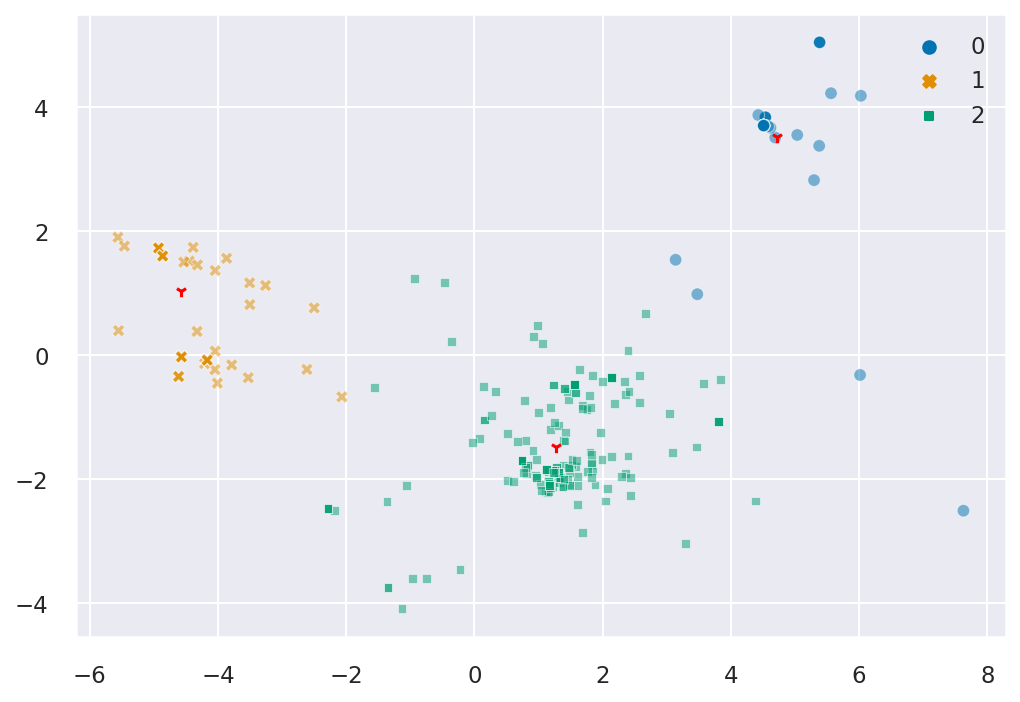

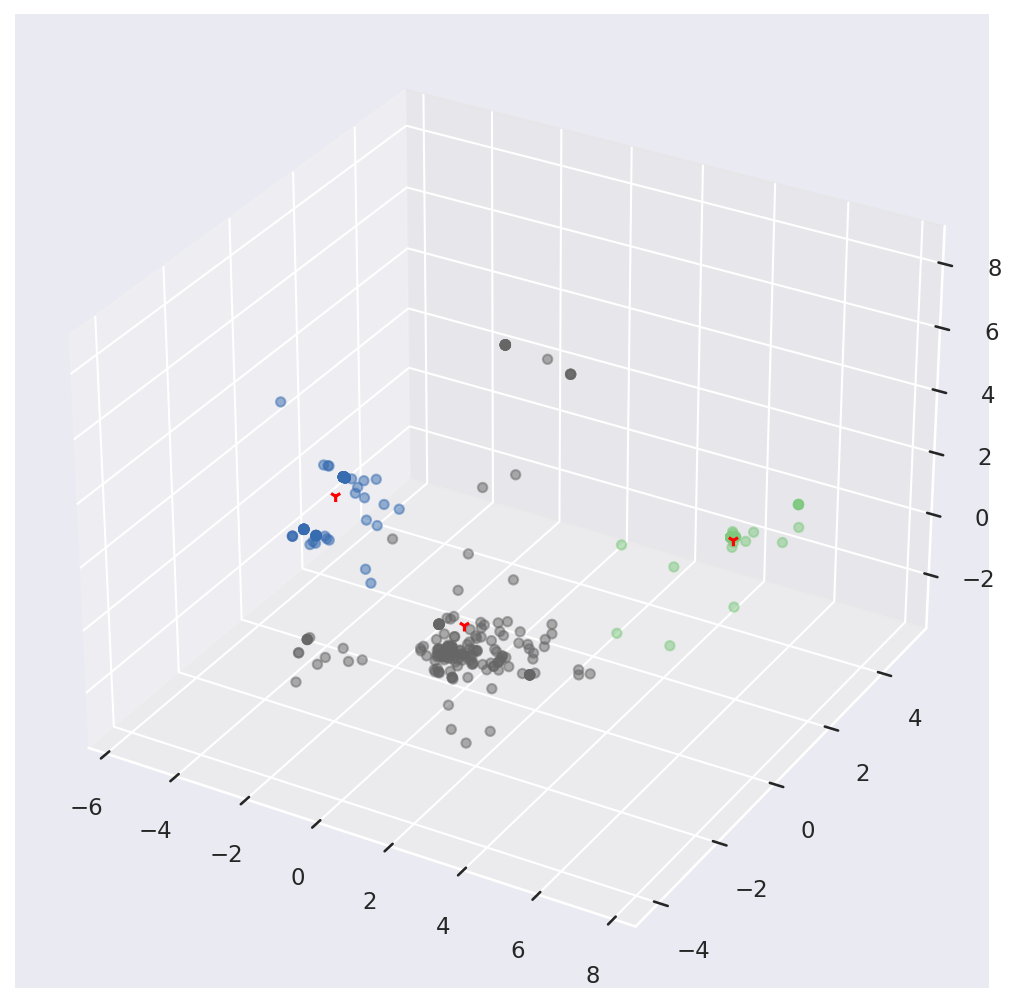

In [35]:
selected_paragraph_texts = provide_preprocessed_paragraph_texts(
	regexp          =  re.compile(r"antenne", re.IGNORECASE),
	term_black_list = [], 
	printed_samples = 0
)

df_semantic_vectors, dtm_absolute_counts, dtm_relative_counts, dtm_tfidf_counts, dtm_colnames, textunits, shortend_filename_list = provide_feature_matrices(
	list_of_texts            = selected_paragraph_texts, 
	nlp                      = nlp_fast,
	test_on_whole_paragraphs = True
)

perform_and_visualize_clustering(
	feature_matrix               = df_semantic_vectors,
	dtm_absolute_counts          = dtm_absolute_counts,
	dtm_colnames                 = dtm_colnames,
	textunits                    = textunits,
	shortend_filename_list       = shortend_filename_list,
	nlp                          = nlp_fast,
	k                            = 3,
	print_most_influencial_terms = False,
	print_filenames              = False,
	perform_topic_modelling      = True
)

## Cluster für "Waschen"

Hier werden hauptsächliche fertige Textbausteine wieder gefunden.

Building semantic vectors: 100%|██████████| 291/291 [00:18<00:00, 15.40it/s]



For cluster number 0
--------------------------------

0.023*"nicht" + 0.021*"mieter" + 0.017*"vermieter" + 0.013*"wohnung" + 0.010*"haben" + 0.010*"werden" + 0.009*"wäsche" + 0.009*"trocknen" + 0.007*"verpflichten" + 0.006*"gelten"

Das Waschen und Trocknen von Wäsche in der Wohnung ist nicht gestattet. Dies gilt nicht für die sachgemäße Benutzung Einer neuzeitlichen, für den Gebrauch in der Wohnung eingerichteten Haushaltswaschmaschine und Trockenschleuder, sofern hierdurch die Mieträume und das Wohngebäude nicht gefährdet werden und der Mieter den Abschluss einer entsprechenden Hahpﬂichtversicherung nachgewiesen hat. Das Aufstellen solcher Maschinen ist dem Vermieter ... anzuzeigen. Das Aufhängen der Wäsche zum Trocknen in der Wohnung ist in jedem Falle unzulässig. Haus & Grund ... lauferhitzer, Warmwasserbereitungsanlagen, Thermen und ähnliche Anlagen) dıe ausschließlich der Versorgung des Mieters dienen, und anderer Gegenstände, wie z. B. Rollläden inkl. Riegel, Gurte, und Gurtau

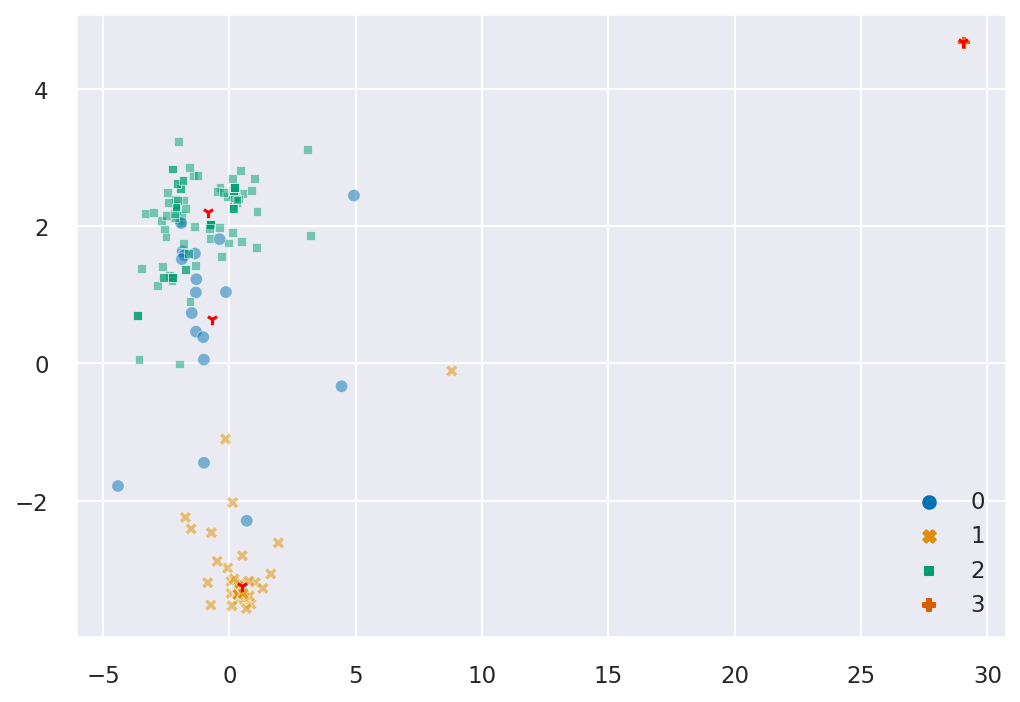

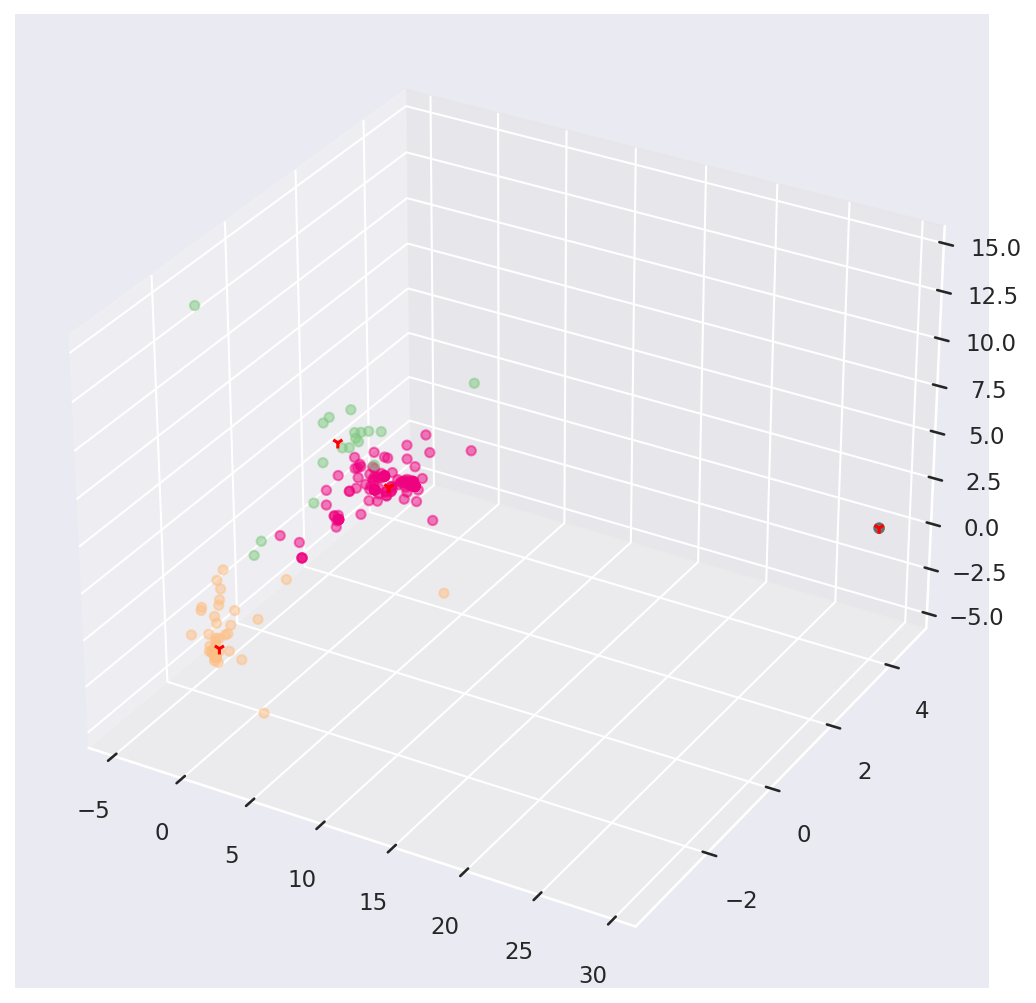

In [36]:
selected_paragraph_texts = provide_preprocessed_paragraph_texts(
	regexp          =  re.compile(r"waschen", re.IGNORECASE),
	term_black_list = [], 
	printed_samples = 0
)

df_semantic_vectors, dtm_absolute_counts, dtm_relative_counts, dtm_tfidf_counts, dtm_colnames, textunits, shortend_filename_list = provide_feature_matrices(
	list_of_texts            = selected_paragraph_texts, 
	nlp                      = nlp_fast,
	test_on_whole_paragraphs = True
)

perform_and_visualize_clustering(
	feature_matrix               = df_semantic_vectors,
	dtm_absolute_counts          = dtm_absolute_counts,
	dtm_colnames                 = dtm_colnames,
	textunits                    = textunits,
	shortend_filename_list       = shortend_filename_list,
	nlp                          = nlp_fast,
	k                            = 4,
	print_most_influencial_terms = False,
	print_filenames              = False,
	perform_topic_modelling      = True
)

## Cluster für "Tierhaltung" vs "Mietzeit / Mietdauer"

Das Clustering kann benutzt werden um (semantisch) verschiedene Paragraphen wieder zu trennen.
Dies kann auch als eine Art Benchmark für das Verfahren angesehen werden.

Building semantic vectors: 100%|██████████| 1306/1306 [02:13<00:00,  9.75it/s]



For cluster number 0
--------------------------------

0.037*"vermieter" + 0.034*"mieter" + 0.028*"einwilligung" + 0.027*"tier" + 0.025*"können" + 0.021*"werden" + 0.020*"nur" + 0.019*"tierhaltung" + 0.013*"all" + 0.013*"zustimmung"

Das Halten von Tieren mit Ausnahme von Kleintieren, wie Zierfische und Wellensittiche bedarf der Einwilligung des Vermieters. Die Einwilligung bezieht sich nur auf ein bestimmtes Tier. Die Einwilligung kann bei Eintritt von Unzuträglichkeiten widerrufen werden. Der Mieter haftet für alle durch die Tierhaltung entstehenden Schäden.

Das Haiten von Tieren mit Ausnahme von Kleintieren wie beispielsweise Zierfischen und Wellensittichen bedarf der Einwilligung xermieters. Die Einwilligung soll schriftlich erfolgen. Die Einwilligung bezieht sich in diesem Fall nur äuf ein bestimmtes Tier. Siednn widerrufen werden, wenn Unzuträglichkeiten eintreten. Der Mieter haftet für alle durch die Tierhaltung entstandenen Schäden. Aus einer anderweitigen Tierhaltung kann de

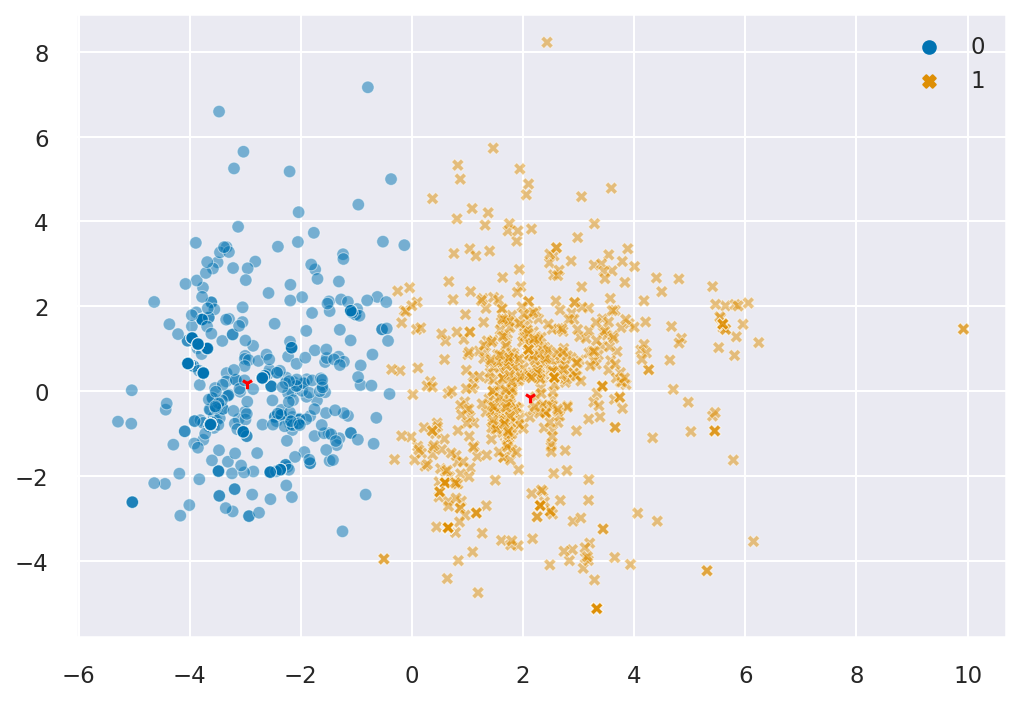

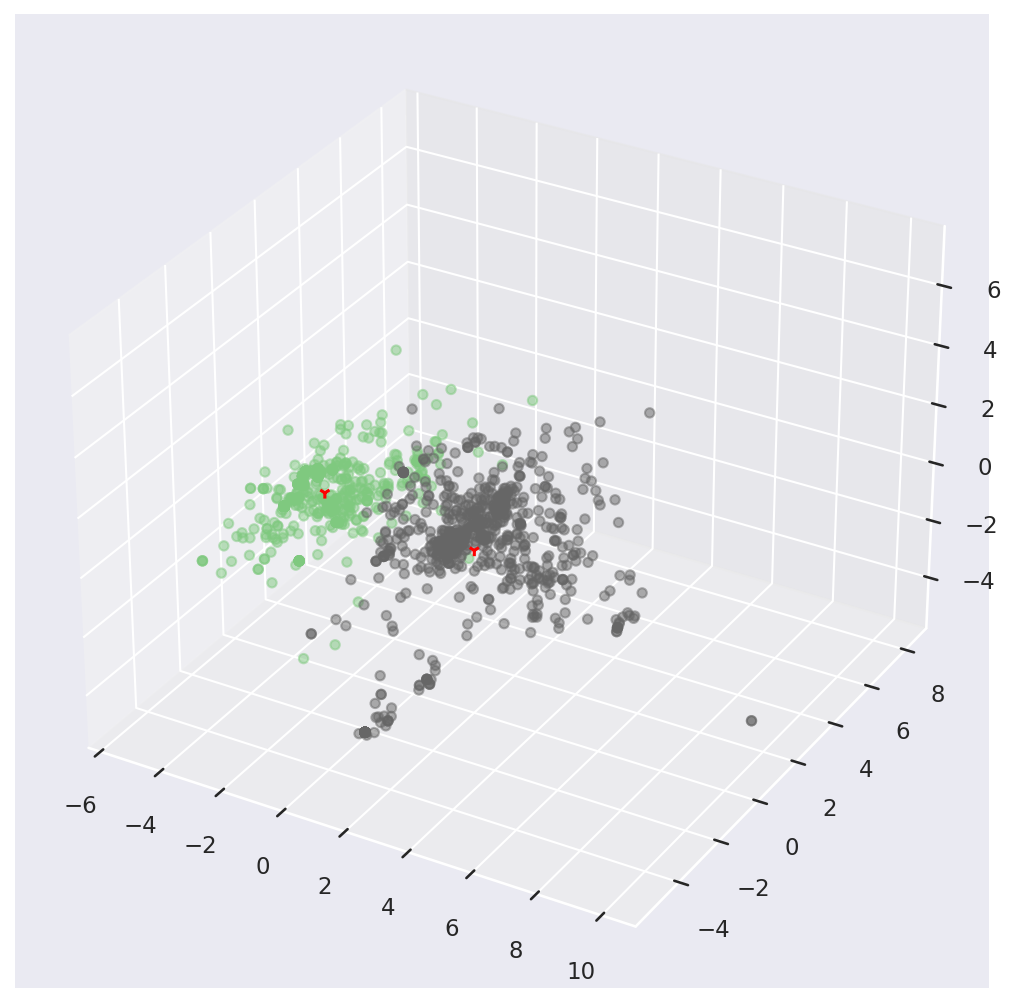

In [37]:
selected_paragraph_texts = provide_preprocessed_paragraph_texts(
	regexp          =  re.compile(r"(mietzeit)|(mietdauer)|(tier)", re.IGNORECASE),
	term_black_list = [], 
	printed_samples = 0
)

df_semantic_vectors, dtm_absolute_counts, dtm_relative_counts, dtm_tfidf_counts, dtm_colnames, textunits, shortend_filename_list = provide_feature_matrices(
	list_of_texts            = selected_paragraph_texts, 
	nlp                      = nlp_fast,
	test_on_whole_paragraphs = True
)

perform_and_visualize_clustering(
	feature_matrix               = df_semantic_vectors,
	dtm_absolute_counts          = dtm_absolute_counts,
	dtm_colnames                 = dtm_colnames,
	textunits                    = textunits,
	shortend_filename_list       = shortend_filename_list,
	nlp                          = nlp_fast,
	k                            = 2,
	print_most_influencial_terms = False,
	print_filenames              = False,
	perform_topic_modelling      = True
)

## Cluster für "Tierhaltung"

Kaum eine sinnvolle Unterscheidung möglich.
Eventuell könnte man sagen, dass Texte erkannt werden, in denen von "Kleintieren" die Rede ist, vs. andere Texte.

Building semantic vectors: 100%|██████████| 415/415 [00:17<00:00, 23.64it/s]



For cluster number 0
--------------------------------

0.073*"einwilligung" + 0.054*"tier" + 0.040*"können" + 0.040*"mieter" + 0.040*"tierhaltung" + 0.032*"werden" + 0.031*"nur" + 0.028*"vermieter" + 0.028*"unzuträglichkeiten" + 0.028*"all"

Das Hatten von Tieren, mit Ausnahme von Kleinteren wie Zierfische und Wellensittiche, Vermieters. Die Einwilligung bezieht sich nur auf ein besimmtes Tier. Die Einwiligung kann bei werden. Der Mieter haftet für alle durch die Tierhaltung entstehenden Schäden

Das Halten von Tieren mit Ausnahme von Kleintieren wie beispielsweise Zierfischen und Wellensittichen bedarf der Einwilligung des Vermieters. Die Einwilligung soll schriftlich erfolgen. Die Einwilligung bezieht sich in diesem Fall nur auf ein bestimmtes Tier. Sie kann widerrufen werden, wenn Unzuträglichkeiten eintreten. Der Mieter haftet für alle durch die Tierhaltung entstandenen Schäden. ı 's einer anderweitigen Tierhaltung kann der Mieter keine Rechte herleiten.

Das Halten von Tieren, mi

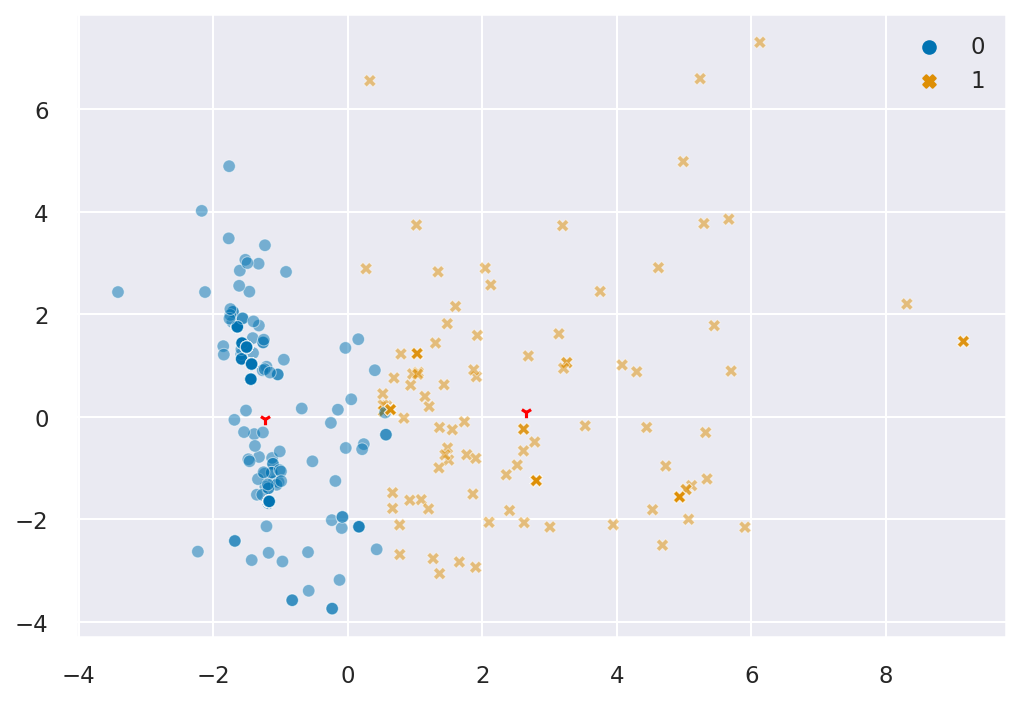

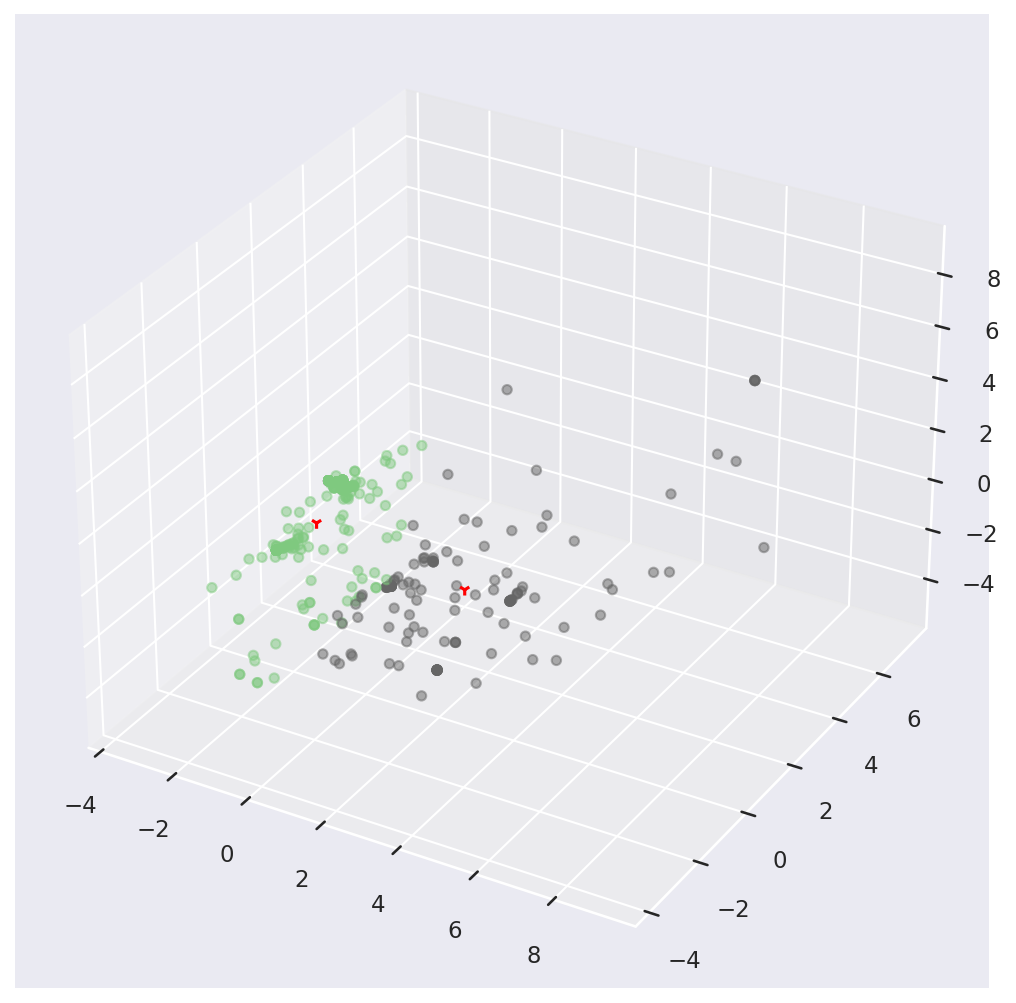

In [38]:
selected_paragraph_texts = provide_preprocessed_paragraph_texts(
	regexp          =  re.compile(r"(tier)", re.IGNORECASE),
	term_black_list = ["Benutzung", "Gartenpflege", "investierten", "Zustimmung", "Warmwasserversorgung", "Untervermietung", "Taubenfütterung", "bedarf"], 
	printed_samples = 0
)

df_semantic_vectors, dtm_absolute_counts, dtm_relative_counts, dtm_tfidf_counts, dtm_colnames, textunits, shortend_filename_list = provide_feature_matrices(
	list_of_texts            = selected_paragraph_texts, 
	nlp                      = nlp_fast,
	test_on_whole_paragraphs = True
)

perform_and_visualize_clustering(
	feature_matrix               = df_semantic_vectors,
	dtm_absolute_counts          = dtm_absolute_counts,
	dtm_colnames                 = dtm_colnames,
	textunits                    = textunits,
	shortend_filename_list       = shortend_filename_list,
	nlp                          = nlp_fast,
	k                            = 2,
	print_most_influencial_terms = False,
	print_filenames              = False,
	perform_topic_modelling      = True
)

# Komplette NLP Pipeline für Mietverträge

In diesem Abschnitt fügen wir alle oben definierten Methoden und Verfahren zu einer Pipeline zusammen um einen Mietvertrag zu analysieren.

In [39]:
import json

def information_extraction_result_to_return_list(information_dict, orignal_content="", position_map=None):
	ret_list = []
	for ret_item in information_dict:
		# This is a hack when "Tierhaltung" is extracted via headline-search. Then, there is no pre-processed text to be returned, but only original content
		if ret_item[4] != 42:
			return_dict = {
				"pre_processed_information_string": ret_item[0],
				"pre_processed_start_pos":          ret_item[1],
				"pre_processed_end_pos":            ret_item[2],
				"lemmatized_tokens":                [token.lemma_ for token in ret_item[3]],
				"score":                            ret_item[4],
			}
			if not position_map is None and orignal_content != "":
				return_dict["original_start_pos"]          = position_map[return_dict["pre_processed_start_pos"]]
				return_dict["original_end_pos"]            = position_map[return_dict["pre_processed_end_pos"]]
				return_dict["original_information_string"] = orignal_content[return_dict["original_start_pos"]:return_dict["original_end_pos"]]
		else:
			return_dict  = {
				"pre_processed_information_string": "",
				"pre_processed_start_pos":          -1,
				"pre_processed_end_pos":            -1,
				"lemmatized_tokens":                [token.lemma_ for token in ret_item[3]],
				"score":                            ret_item[4],
				"original_start_pos":               ret_item[1],
				"original_end_pos":                 ret_item[2],
				"original_information_string":      ret_item[0],
			}
		ret_list.append(return_dict)
	
	return ret_list


def list_of_warnings(content):
	warnings = []
	
	ratio_valid_chars     = ratio_of_valid_characters(content)
	valid_chars_threshold = 0.98194                           # = median - 3  *iqr
	if ratio_valid_chars < valid_chars_threshold:
		warnings.append(f"The ratio of valid vs. invalid characters is lower than the needed threshold: {ratio_valid_chars} < {valid_chars_threshold}.")
	
	return warnings


def nlp_pipeline_to_analyze_a_rental_contract(content):
	""" Analyzes a rental contract.
	    Expects a String as input.
	    
	    Returns the result as a JSON String.
	"""
	
	# 1. Initialize spaCy. Choose between "de_core_news_lg" and "de_dep_news_trf".
	nlp = spacy.load("de_core_news_lg")

	# 2. Extract the headlines before doing any pre-processing (because the extraction method is optimized for raw OCR input).
	headlines = find_headlines(content, nlp)
	
	# 3. Perform some basic pre-processing for the next steps. Keep track of the position-mappings to the original String.
	pre_processed_content, position_map = basic_preprocessing(content, True)
	
	# 4. Use spaCy to parse the pre-processed content.
	doc = nlp(pre_processed_content)
	
	# 5. Extract all "Quick facts"
	information_befristung            = extract_information_befristung(doc)
	information_abschlussdatum        = extract_information_abschlussdatum(doc)
	information_mietbeginn            = extract_information_mietbeginn(doc)
	information_kuendigungsausschluss = extract_information_kuendigungsausschluss(doc)
	information_kuendigungsfrist      = extract_information_kuendigungsfrist(doc)
	information_549bgb                = extract_information_549bgb(doc)
	information_tierhaltung           = extract_information_tierhaltung(doc, content, nlp)
	information_postleitzahl          = extract_information_postleitzahl(doc)
	
	# 6. Contruct the return object that will be serialized to JSON.
	ret_obj = {
		"original_content":      content,
		"pre_processed_content": pre_processed_content,
		"position_mapping":      position_map,
		"analysis_results":      {
			"warnings":  list_of_warnings(content),
			"headlines": {
				"found_headlines":   headlines,
				"missing_headlines": [],
			},
			"quick_facts": {
				"befristung":            information_extraction_result_to_return_list(information_befristung,            content, position_map),
				"abschlussdatum":        information_extraction_result_to_return_list(information_abschlussdatum,        content, position_map),
				"mietbeginn":            information_extraction_result_to_return_list(information_mietbeginn,            content, position_map),
				"kuendigungsausschluss": information_extraction_result_to_return_list(information_kuendigungsausschluss, content, position_map),
				"kuendigungsfrist":      information_extraction_result_to_return_list(information_kuendigungsfrist,      content, position_map),
				"549bgb":                information_extraction_result_to_return_list(information_549bgb,                content, position_map),
				"tierhaltung":           information_extraction_result_to_return_list(information_tierhaltung,           content, position_map),
				"postleitzahl":          information_extraction_result_to_return_list(information_postleitzahl,          content, position_map),
			},
			"anomalies": [],
		},
	}
	
	# 7. Serialize to JSON and encode as UTF-8.
	return json.dumps(ret_obj, ensure_ascii=False).encode('utf8')

In [40]:
sample_content                                        = read_file_with_correct_encoding(f"../data/original/clr_MV{828}.pdf.txt")
sample_json_return_as_string                          = nlp_pipeline_to_analyze_a_rental_contract(sample_content).decode()
sample_json_return_as_object                          = json.loads(sample_json_return_as_string)
sample_json_return_as_object['original_content']      = ''
sample_json_return_as_object['pre_processed_content'] = ''
sample_json_return_as_object['position_mapping']      = ''
print(json.dumps(sample_json_return_as_object, ensure_ascii=False, indent=4))

{
    "original_content": "",
    "pre_processed_content": "",
    "position_mapping": "",
    "analysis_results": {
        "warnings": [],
        "headlines": {
            "found_headlines": [
                [
                    "8 1 Mieträume",
                    11,
                    80
                ],
                [
                    "8& 2 Mietzeit",
                    22,
                    80
                ],
                [
                    "$ 3 Miete",
                    32,
                    80
                ],
                [
                    "8 4 Pflichten des Vermieters vor Einzug",
                    81,
                    80
                ],
                [
                    "$ 5 Mängel und Schäden an der Wohnung",
                    89,
                    80
                ],
                [
                    "... ... Ausbesserungen und bauliche Veränderungen",
                    118,
                    80
             

# NLP Resourcen

* Sowmya V. B, B. Majumder, A. Gupta, und H. Surana, Practical natural language processing: a comprehensive guide to building real-world NLP systems, First edition. Sebastopol, CA: O’Reilly Media, 2020.
	* z.B. als Quelle für pre-processing
* R. Feldman und J. Sanger, The text mining handbook: advanced approaches in analyzing unstructured data. Cambridge ; New York: Cambridge University Press, 2007.
	* z.B. als Quelle für Clustering
	* z.B. als Quelle für Information Retrieval
* C. D. Manning, P. Raghavan, und H. Schütze, Introduction to information retrieval. New York: Cambridge University Press, 2008.
	* ein Klassiker
	* z.B. als Quelle für Information Retrieval
* G. Heyer, U. Quasthoff, und T. Wittig, Text Mining: Wissensrohstoff Text: Konzepte, Algorithmen, Ergebnisse, 2. Nachdr. Herdecke: W3L-Verl, 2012.
	* Buch von Prof. Heyer aus der ASV von der Uni Leipzig.
	* z.B. als Quelle für Information Retrieval
	* z.B. als Quelle für Information Retrieval
* C. D. Manning und H. Schütze, Foundations of statistical natural language processing. Cambridge, Mass: MIT Press, 1999.
	* ein weiterer Klassiker

# Archiv

Beinhaltet Source Code, welcher für die finale Umsetzung nicht mehr genutzt wird.
Dieser Source Code kann aber trotzdem noch zum (manuellen) Experimentieren genutzt werden.

In [41]:
import re
from colorama import Fore, Back, Style

def find_and_print_regular_expression(regexp, content, surrounding=5):
	""" This is a helper method to print found matches of a Regular Expression in a colored way.
	    Ths will help to verify the correctness of our Regular Expressions.
	"""
	for match in re.finditer(regexp, content):
		start, stop = match.span()[0], match.span()[1]
		print(content[max(0, start-surrounding):start],          end='')
		print(Fore.RED + content[start:stop] + Style.RESET_ALL,  end='')
		print(content[stop:min(stop+surrounding, len(content))])

Diese regulären Ausdrücke könnten eventuell benutzt werden um die Daten zu reinigen.

In [42]:
RE_TAGS         = re.compile(r"<[^>]+>")                            # Do not use this regexp. It will find 100_000 lines which are actually text. No HTML tags could be found.
RE_HTML         = re.compile(r"<.*br.*>")                           # < /br> could not be found.
RE_ASCII        = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)       # Do not use this regexp (yet). It will also delete numbers, and chars like "$" and "§" which are helpfull to detect headlines.
RE_SINGLECHAR   = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)     # Note for "À-ž" -> https://stackoverflow.com/a/44586972 to see which chars are included. Will also find text like "a)" which might be helpfull.
RE_WSPACE       = re.compile(r"\s+", re.IGNORECASE)                 # Will probably also be done by spaCy.
RE_ASCII_2      = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
RE_SINGLECHAR_2 = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

for content in rental_contract_dataframe['raw_content']:
	find_and_print_regular_expression(regexp=RE_SINGLECHAR, content=content)

 559 b BGB 
 er

a) die
ch),
b) die
st,

c) Sch
lt,

d) Tie
elt (z. B. 
 (z. B. Fis
rt,

e) Ant
rt,

f) von
ht,

g) in 
ll,

h) Um-
nd,

i) Hei
ill,
j)weit
s. 1 a) gel

554 a BGB.
enn

a) der
der

b) der
der

c) der
der

d) in 
tzt; d.h.
8
t; d.h.
8 5





A

vit
2,65 m?.
Di
8,60 m°*.



Gar.u.Abst
vor, z.B. b
r, z.B. bei
gem. S 565 
gem. S 565 
 ... a) Gem
en.

S 2 Mi
 EUR
a) Die
 von S 27 d
gen

a) lau
cks

b) Was
ung

c) Rei
ten

d) Kos
ung

e) Auf
ug

£f) Str
uhr

g) Hau
ung

h) Gar
ege

i) Bel
ung

j) Sch
ung

k) Sac
ung

l) Hau
art

m) Gem
ng)

n) pri
tz

©o) Gru
uss

p) War
age

q) Tie
age

r) son
 wie z.B.
-
ie z.B.
-Mü
eit

a) Gru
hluß
b) Rei
iten
c) Kos
ten

d) Hei
uch

A AA %
raum B ... 
che

e) War
ö8

£f) Was
ung

a) die
AVB)
b) die
AVB)
c) die
tet (s. 83)


 

S 5 Au
nd:

a) Die
koll
b) Die
VB)

c) Hau
R WK K

V1t
errr%x\l"la
rr%x\l"la:.
"la:.n GmbH
ER

(a) Die
sse) i.S.v.
e) i.S.v. S
 i.S.v. S 8
S.v. S 87 a
S 87 a Zwei
s.

(b) Die
it 6 v.H. e
 6 v.H. erf
d.

(c) Tei
n.



Nächsten Schritte zum Ausprobieren:

1. Die *wichtigsten Punkte (Quick Facts)* aus einem Mietvertrag extrahieren
    * kann am Anfang noch stark regelbasiert erfolgen. Wenn dann (sozusagen gelabelte) Daten vorliegen, können weitere Supervised Machine Learning Verfahren genutzt werden um Stellen noch besser zu identifizieren.
    * Extrahierte Aussagen aus den Mietverträgen clustern und Bewertungen treffen (z.B. "Haustiere sind erlaubt", weil der Satz "...." in das Cluster "haustiere_erlaubt" fällt)
    * Folgende Punkte finden:
        1. Ist der Mietvertrag befristet abgeschlossen?   Anwort: Ja / Nein
            * falls ja:
                * wie lang?   Antwort: Monate / Woche / Tage oder genaues Datum
                * werden Gründe angegeben?   Antwort: Ja / Nein
                    * falls ja,   Antwort: Auswahl aus 4 möglichen Gründen:
                        * Vermieter:in möchte die Räume als Wohnung für sich, Familienangehörige oder Angehörige des Haushalts nutzen (Eigenbedarf)
                        * Vermieter:in möchte in zulässiger Weise die Räume beseitigen oder so wesentlich verändern oder instand setzen will, dass die Maßnahmen durch eine Fortsetzung des Mietverhältnisses erheblich erschwert würden
                        * Vermieter:in möchte die Räume an zur Dienstleistung Verpflichtete vermieten
                        * keiner der benannten Gründe
        2. Zu welchem Datum wurde der Mietvertrag abgeschlossen?   Antwort: Datum
        3. An welchem Datum beginnt das Mietverhältnis?   Antwort: Datum
        4. Befindet sich eine Regelung, die einen Kündigungsausschluss zum Gegenstand hat, im Mietvertrag? (teilweise auch als „beidseitiger Kündigungsverzicht“ bezeichnet)?   Antwort Ja / Nein
            * falls ja: wie lang?   Antwort: Monate / Woche / Tage oder genaues Datum
        5. Existiert im Mietvertrag eine Regelung, die Kündigungsfristen betrifft?   Antwort Ja / Nein
            * falls ja: wie lang ist die Kündigungsfrist?   Antwort: Monate / Woche / Tage oder genaues Datum
        6. Handelt es sich um ein Mietverhältnis nach § 549 II Nr. 2 BGB?   Antwort: Ja / Nein
        7. Befindet sich im Mietvertrag eine Regelung, die die Zulässigkeit der Tierhaltung in der Wohnung betrifft?    Antwort: Auswahl aus 5 Sachverhalten:
            * Ja, die Haltung von Tieren wird umfassend verboten.
            * Ja, die Haltung von Tieren wird mit Ausnahme der Haltung von Kleintieren verboten.
            * Ja, die Vermietung behält sich das Recht vor, nach freiem Ermessen die Tierhaltung zu gestatten oder zu untersagen.
            * Ja, es existiert eine Regelung die Tierhaltung betreffend. Ihr Inhalt weicht jedoch von den zur Verfügung stehenden Antwortmöglichkeiten ab
            * Nein, es existiert keine Regelung.
        8. In welchem Ort befinden sich die Mieträume?    Antwort: Postleitzahl
2. *Anomalie-Erkennung auf Überschriften-Basis*
    * Überschriften-Erkennung noch weiter verbessern durch entweder:
        1. weitere manuelle Inspektion der Mietverträge und Regelanpassungen
        2. oder semi-automatische Erkennung: bisher gefundene Überschriften-Zeilen (und der Rest aus Nicht-Überschriften-Zeilen) können nun als gelabelte Daten betrachtet werden und es können Supervised Machine Learning Verfahren angewendet werden
    * Ähnliche Überschriften (= ähnliche Semantik der darauffolgenden Absätze) matchen (z.B. "Haustierhaltung" und "Tierhaltung" und "Haustiere" haben vermutlich den selben semantischen Inhalt) und unifizieren.
        * Topic Modelling?
        * Evtl. auch durch semantische Embeddings für alle Paragraphen, und dann clustern (Cluster-Anzahl vorgeben oder das ML-Verfahren entscheiden lassen)
    * Anomalie-Erkennung durch:
        1. Erkennen von (vorher als wichtig festgelegten) fehlenden Überschriften in einem neuen Dokument
        2. Mittels Clustering Verfahren
            * Was sind dafür gute Features? Testen:
                * Lemmatisierte Unigramme
                * Word-Embeddings
                * Latent Semantic Indexing (LSI)
            * Festlegen auf genau 2 Klassen vorher? Dann schauen, zu welcher Klasse ein neuer Mietvertrag gehört.
            * ML Verfahren, dass Anzahl an Cluster selbst bestimmt
            * 2D Visualisierung der Cluster (mit PCA?)
3. Trigger Wörter suchen und 10 Wörter links und rechts vom Triggerwort (daraus evtl. Embedding machen; inkl "nicht", "kein", ...?)
    * z.B. verpflichtend, ausgeschlossen, eingeräumt, untersagt; also quasi Rechte und Pflichten und Gültigkeitsbereiche
        * Das auch als Zusammenfassung nutzen?


Ideen-Archiv:
1. *Texte im iLCM (https://ilcm.informatik.uni-leipzig.de/) explorieren*
    * (war nicht erfolgreich)
2. *Wichtigsten Satz* eines Paragraphen ausgeben
    * Summarization-Verfahren möglich? 
3. Sonstige Ideen:
    * Autoencoder?
4. *Anomalie-Erkennung auf gesamten Dokumenten*
    1. Mittels Signifikanztests
        * DTM mit Häufigkeit aller Wörter (z.B. Dokument-absolut, Dokument-relativ, (TF-IDF)) für alle selektierten Mietverträge
        * Annahme, dass die (relative, auf Textlänge normierte) Häufigkeiten einzelner Wörter einer Normalverteilung folgt, über alle Dokumente hinweg
            * prüfen, welche Wörter in einem neuen Mietvertrag signifikant von Normalverteilung abweichen
            * In welchen Abschnitten kommen diese Wörter (nicht) vor? Diese Abschnitte / Sätze ausgeben
        * Thomas Efer meint, dass das genau nicht funktioniert, wie z.B. bei Spam. Und das viele Wörter (Zipf) in einem Dokument nur 0 oder 1 mal vorkommen.

Unsere Vorführ-Mietverträge sind (vorläufig):
*  20
* 131
* 320
* 345
* 350
* 413
* 828

Jetzt konstrtuieren wir the Dokument-Term-Matrix. Als "Terme" benutzen wir lemmatisierte Tokens. Als Dokumente benutzen wir die zuvor selektierten Mietverträge. Da die Berechnung (auf Sascha's Computer) ca. 20 Minuten dauert, speichern wir das Ergebnis in einem serialisiertem Format (Pickle) ab, um es später schneller wieder laden zu können.

In [43]:
import pickle

def provide_dtm(perform_recalculation=False):
	# If we want to perform a full re-creation of the DTM (e.g. when doing experiments with different features).
	if perform_recalculation:
		# Full DTM creation takes around 20 minutes on Sascha's machine.
		list_of_documents                                                                            = selected_rental_contract_dataframe['raw_content']
		dtm_absolute_counts, colnames_absolute_counts, dtm_relative_counts, colnames_relative_counts = construct_dtm(list_of_documents, nlp_fast)
		
		with open('../data/processed/dtm_absolute_lemma_no_punct_no_space_no_digit.pickle', 'wb') as file:
			pickle.dump(dtm_absolute_counts, file)
			
		with open('../data/processed/colnames_for_dtm_absolute_lemma_no_punct_no_space_no_digit.pickle', 'wb') as file:
			pickle.dump(colnames_absolute_counts, file)
		
		with open('../data/processed/dtm_relative_lemma_no_punct_no_space_no_digit.pickle', 'wb') as file:
			pickle.dump(dtm_relative_counts, file)
			
		with open('../data/processed/colnames_for_dtm_relative_lemma_no_punct_no_space_no_digit.pickle', 'wb') as file:
			pickle.dump(colnames_relative_counts, file)
	# Or when we just want to quickly load the pre-calculated results from HDD.
	else:
		with open('../data/processed/dtm_absolute_lemma_no_punct_no_space_no_digit.pickle', 'rb') as file:
			dtm_absolute_counts      = pickle.load(file)
			
		with open('../data/processed/colnames_for_dtm_absolute_lemma_no_punct_no_space_no_digit.pickle', 'rb') as file:
			colnames_absolute_counts = pickle.load(file)
		
		with open('../data/processed/dtm_relative_lemma_no_punct_no_space_no_digit.pickle', 'rb') as file:
			dtm_relative_counts      = pickle.load(file)
			
		with open('../data/processed/colnames_for_dtm_relative_lemma_no_punct_no_space_no_digit.pickle', 'rb') as file:
			colnames_relative_counts = pickle.load(file)
	
	return dtm_absolute_counts, colnames_absolute_counts, dtm_relative_counts, colnames_relative_counts

dtm_absolute_counts, colnames_absolute_counts, dtm_relative_counts, colnames_relative_counts = provide_dtm(perform_recalculation=False)

Wir berechnen für jedes Features den Mittelwert und die Standardabweichung. 
Wir wissen dann also, dass ein Feature A im Durchschnitt mit einer relativen Häufigkeit von H_A in einem Dokument auftritt. 
Wie zu erwarten, sind die Auftrittwahrscheinlichkeiten von Features (= Wörter) Zipf-verteilt (https://de.wikipedia.org/wiki/Zipfsches_Gesetz). 
Das heißt, es gibt wenig Wörter, die sehr häufig vorkommen und es gibt viele Wörter, die sehr selten vorkommen. 
Daher bildet sich bei einer log-log Darstellung eine (fast) gerade Linie.

Hinweis: Auch die Standard-Abweichungen sind Zipf-Verteilt. 
Eine Erklärung könnte sein, dass bei niedrigen Auftrittswahrscheinlichkeiten auch die Abweichungen von diesen niedrigen Auftrittwahrscheinlichkeiten (bei Annahme Normalverteilung) klein ist.

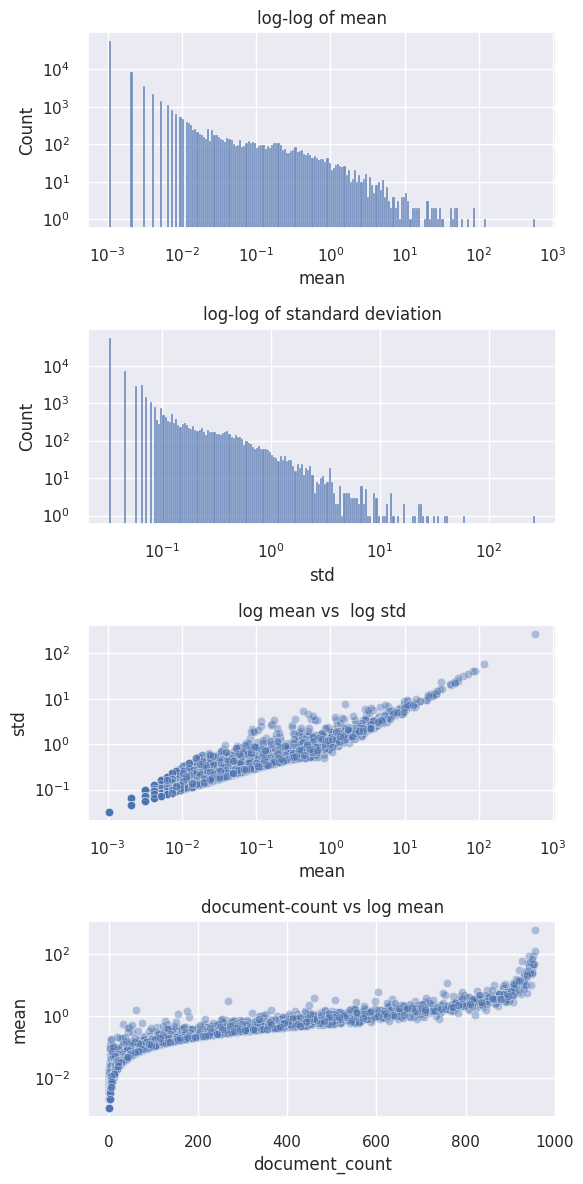

In [44]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Increase figure DPI for sharper plots.
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})

# Use the StandardScaler for fast calculation of mean and variance for each feature in the DTM. The scaled data is not needed.
scaler = StandardScaler(with_mean=False)
_      = scaler.fit_transform(dtm_absolute_counts)

# Create a Pandas DataFrame to keep track of features vs mean and std.
mean_var_df = pd.DataFrame(index=["mean", "std", "document_count"], columns=colnames_absolute_counts)
mean_var_df.loc["mean"]           = scaler.mean_
mean_var_df.loc["std"]            = np.sqrt(scaler.var_)
mean_var_df.loc["document_count"] = list(dtm_absolute_counts.getnnz(axis=0))

# Plot relationsships
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(6,12), dpi=100)
sns.histplot(   ax=ax1, data=mean_var_df.loc['mean'], bins=200, log_scale=(True, True)       ).set(title = "log-log of mean");
sns.histplot(   ax=ax2, data=mean_var_df.loc['std'],  bins=200, log_scale=(True, True)       ).set(title = "log-log of standard deviation");
sns.scatterplot(ax=ax3, data=mean_var_df.transpose(), x='mean',           y='std',  alpha=0.4).set(title = "log mean vs  log std",       xscale = 'log', yscale = 'log');
sns.scatterplot(ax=ax4, data=mean_var_df.transpose(), x='document_count', y='mean', alpha=0.4).set(title = "document-count vs log mean",                 yscale = 'log');
plt.tight_layout()

Verteilung für einige ausgewählte Wörter.

Beobachtungen:
* für Features, die in vielen Dokumenten vorkommen, scheint die relative Häufigkeit normal-verteilt zu sein.
  (z.B. "der", "mieter", "kosten", "wenn", "höhe", "tierhaltung")
* je seltener die Features werden (= um so näher sie an 0 heranrücken), um so mehr scheint die Verteiltung linkssteil, bzw. rechtsschief zu werden.
* Dies ist evtl. ein Indiz, dass wir die Auftritts-Wahrscheinlichkeit als eine Poisson-Verteilung modellieren könnten

In [45]:
" ".join(colnames_relative_counts)

'aa aaa aaaa aaag aaagn aaagr aaahasalahaıuna aaahe aaal aaala aaaln aaan aaana aaanl aaannn aaanr aaanı aaaqay aaar aaara aaarn aaarschl aaarı aaat aaaur aaaı aaaıa aab aabgeschlassenen aabhrp aable aablitz aabllitz aabnid aabı aac aaca aacchinel aach aacheasmiuna aachener aachung aaclter aacmst aad aadaira aaderung aadmcic aae aaefvaltage aaei aaeindhet aaerf aaeudvar aaf aag aahan aahlemr aahlt aahmen aahna aaho aahr aaht aaie aainen aaipy aaitelle aal aala aalaecana aalanf aalavee aalean aalen aalera aalf aallır aaln aalox aalr aals aalsahr aaltung aaltzf aam aamaincchaflich aame aamu aan aanale aanee aanenerwae aanhlbürhean aankleitzahvkcntonummer aanl aanll aanlt aannn aanr aanranntan aanteilıg aanvä aanwor aanz aanzgiy aanı aanırnaf aao aaone aaqa aar aara aarah aaraııf aarbdeswdom aareal aarf aarg aargn aarin aarl aarn aarr aarı aas aasamunrsei aasat aash aasie aaso aasr aass aassenn aasserkosten aasstv aast aastigrer aaten aatiscgaehnl aatk aatou aatyc aatäeeree aau aaubnis aa

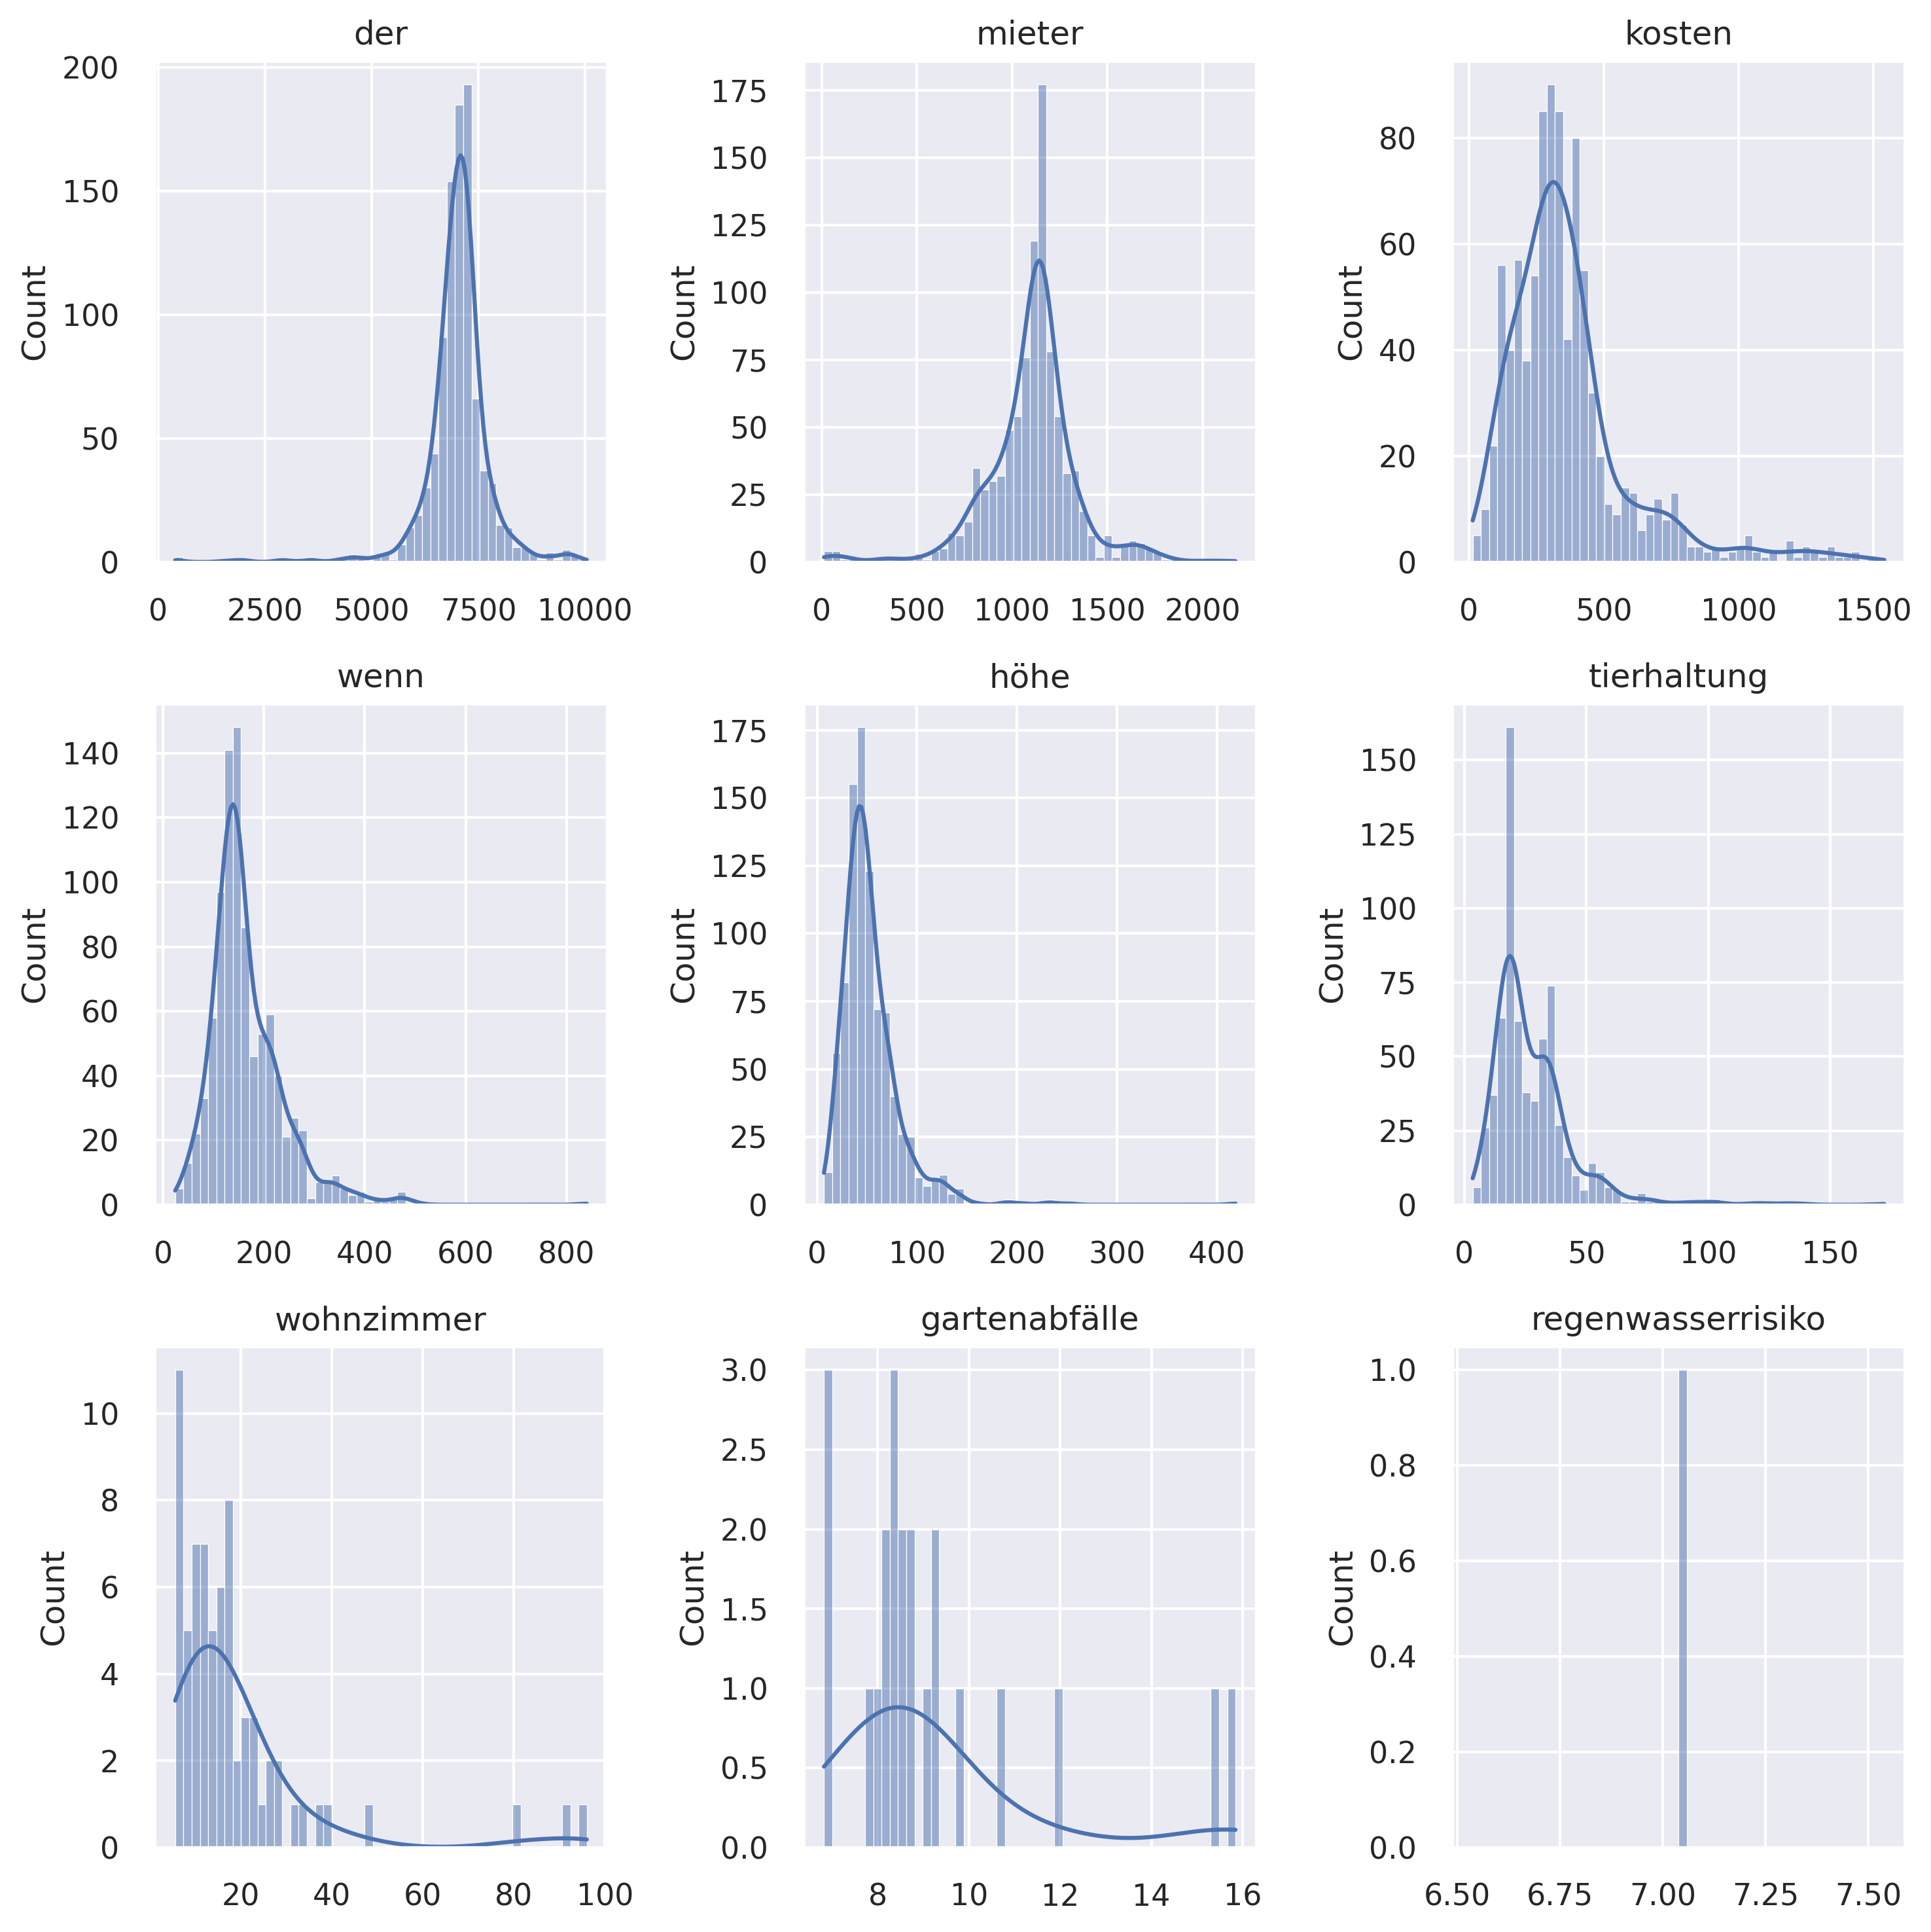

In [46]:
# To manually identify interesting words.
# tr_df = mean_var_df.transpose()
# tr_df[ (tr_df['mean'] > 0.00001) & (tr_df['mean'] < 0.0001) ].sample(10, replace=True)

word_list = [
	'der',               #   0.135387
	'mieter',            #   0.021002
	'kosten',            #   0.006855
	'wenn',              #   0.003097
	'höhe',              #   0.000960
	'tierhaltung',       #   0.000378
	'wohnzimmer',        #   0.000027
	'gartenabfälle',     #   0.000004
	'regenwasserrisiko', # < 0.000001
]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10), dpi=300)

for idx, word in enumerate(word_list):
	word_column_index = list(colnames_relative_counts).index(word)
	word_frequencies  = list(dtm_relative_counts[:,word_column_index].toarray().flat)
	word_frequencies  = list(filter(lambda a: a > 0, word_frequencies))               # optional: remove all 0.0 = documents where the feature did not occure.
	word_frequencies  = list(map(   lambda a: 50000 * a, word_frequencies))            # optional: scaling
	# word_frequencies  = list(map(   lambda a: np.log(a), word_frequencies))         # optional: scaling
	sns.histplot(data=word_frequencies, bins=50, kde=True, ax=axes[idx//3][idx%3]).set(title = f"{word}");

plt.tight_layout()

Ein Versuch, die OCR Qualität mit spaCy zu erkennen.

In [47]:
def is_token_invalid(token):
	return token.is_oov and not token.is_space           or \
	       token.tag_      == "$("                       or \
	       token.tag_      == "NE"                       or \
	       token.tag_      == "XY"                       or \
	       len(token.text) == 1 and not token.is_digit


def ratio_of_valid_tokens(content, nlp):
	doc                = nlp(content)
	total_num_tokens   = len(doc)
	num_invalid_tokens = np.array([is_token_invalid(token) for token in doc]).sum()
	
	return (total_num_tokens - num_invalid_tokens) / total_num_tokens

# Takes around 20 minutes on Sascha's machine.
# rental_contract_dataframe['valid_token_ratio'] = np.vectorize(ratio_of_valid_tokens)(rental_contract_dataframe["raw_content"], nlp_large)

# Visualize.
# sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
# sns.displot(data=rental_contract_dataframe['valid_token_ratio'], bins=500, kde=True).set(title = "valid token ratios");

### For manual exploration:
# content = rental_contract_dataframe["raw_content"][10]
# content = "Die Untermietvertrag besteht kanr aus insgesamt (5) Zimmern jC<SÜ”? fj/’“« As FE /£/‘4 &. S25"
# doc     = nlp_large(content)
# a       = [[token.text, is_token_invalid(token), token.lemma_, , token.norm_, token.pos_, token.tag_, token.is_oov] for token in doc]
# print(pd.DataFrame(data=a))

# Text Cleaning

Um die Rückverfolgbarkeit der Wörter zum Rohtext sicherzustellen, wird jedem Char pro Paragraph und Mietsvertrag ein Index vergeben. D.h. jeder präprozessierte Paragraph definiert ein Array aus Referenz-Indices zum entsprechenden Rohparagraph desselben Vertrags. Werden beim Cleaning-Prozess bestimmte Wörter/Zeichen gelöscht, so löscht man die ensprechenden Indizes aus dem Array. Somit bleiben Positionen der übrig geblieben Characters erhalten.

In [48]:
# List initiation of reference indices to raw paragraphs.
df_selected_files["reference_to_raw"] = list(map(lambda c: [np.arange(0, len(par)).tolist() for par in c ],
					df_selected_files["corrected_pars"]))

/tmp/ipykernel_38253/1851017445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["reference_to_raw"] = list(map(lambda c: [np.arange(0, len(par)).tolist() for par in c ],


### Helper functions

In [49]:
#### Clean special characters in paragraphsfrom functools import partial
from functools import partial

# Function for updatetion of list of reference indices during cleaning step f. 
def adopt_indices(content, idx_list, f):
	"""Helpfunction for certain cleaning process, the function adjusts the list of indices that refer to raw content.
	
	   Input: content  : <list of strings> seperated paragraphs of a rental contract.
	          idx_list : <list of arrays> list of indices of characters corresponding to the content of paragraphs.
	                 f : <function> function for cleaning process over paragraphs of a rental contract.
	   Output:       l1: <list of strings> according to the function, cleaned seperated paragraphs.
	                 l2: <list of arrays> according to the cleaned paragraphs, adjusted list of the reference indices.
	
	"""
	l1, l2 = [], []
	for i in range(len(idx_list)):
		d1,d2 = f(content[i], idx_list[i])
		l1.append(d1)
		l2.append(d2)
	return l1, l2


# Function for generation of a replacement string. The length of the string corresponds to the length of the pattern.
# The length of the pattern is variable.
def repl(m): return ' ' * len(m.group())

### Clean word hyphenations in paragraphs

In [50]:
def delete_hyphenation(content, idx_list):
	""" Delete special characters before new line deletion.
	    SPECIAL_CHARS: word hyphenation (-) cut by new line.     
	
	    Input:  content  : <string> separated single paragraph of rental contract.
	            idx_list : <array list> indices of characters in the content.
	    Output: result_clean_content : <string> content cleaned according to the description.
	            result_idx_list      : <array list> updated list of indexes that refer to characters in the raw paragraph.
	"""
	list_idx_to_remove = []
	SPECIAL_CHARS      = re.compile(r'([a-zA-Z]+)-\n([a-z]+)')
	all_matches        = re.finditer(SPECIAL_CHARS, content)
	
	for match in all_matches: 
		idx_to_del = match.start() + re.search('-\n', match.group()).start()
		list_idx_to_remove.append(idx_to_del    ) # Delete "-".
		list_idx_to_remove.append(idx_to_del + 1) # Delete \n also.
	
	result_clean_content = ''.join(np.delete(list(content), list_idx_to_remove))
	result_idx_list      = np.delete(idx_list, list_idx_to_remove)
	return result_clean_content, result_idx_list


delete_hyphenation_df = partial(adopt_indices, f = delete_hyphenation) # Function that composses two function executions.  
dummy = list(map(lambda x,y: delete_hyphenation_df(x,y),
		 df_selected_files["corrected_pars"], 
		 df_selected_files["reference_to_raw"])) # Run cleaning step over all rental contracts.
df_selected_files["clean_pars_del_chars"], df_selected_files["idx_to_raw_del_chars"] = [i[0] for i in dummy], [i[1] for i in dummy]

/tmp/ipykernel_38253/1988831052.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["clean_pars_del_chars"], df_selected_files["idx_to_raw_del_chars"] = [i[0] for i in dummy], [i[1] for i in dummy]
/tmp/ipykernel_38253/1988831052.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["clean_pars_del_chars"], df_selected_files["idx_to_raw_del_chars"] = [i[0] for i in dummy], [i[1] for i in dummy]


### Replace special characters by whitespaces in paragraphs

In [51]:
def replace_special_chars(content, idx_list):
	"""Raplace special characters with spaces before the cleaning process of whitespaces.
	   SPECIAL_CHARS: multiple dots (.. | ... | .... | etc.), underscore (_ | __ | etc.), url, special chars and FLFI chars
	   
	   Input:  content  : <string> separated single paragraph of rental contract.
	           idx_list : <array list> indices of characters in the content.
	   Output: result_clean_content : <string> content cleaned according to the description.
	           result_idx_list      : <array list> updated list of indexes that refer to characters in the raw paragraph.
	
	"""
	REPLACE_SINGLE_CHAR   = re.compile(r'(\W[A-Za-zäÄöÖüÜß]{1})+\W')
	REPLACE_MULTIPLE_DOTS = re.compile(r'(\.\.+)|(\.([\s]*[\.]+)+)')
	REPLACE_URL           = re.compile(r'((http[s]?:\/\/)|(www\.))[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
	REPLACE_SPECIAL_CHARS = re.compile(r'[^A-Za-z0-9äÄöÖüÜß\s\.,:;&§%\-]+')
	REPLACE_SPECIFIC      = re.compile(r'((Seite)[\s\d]+(von)?[\s\d]*)')
	
	content = content.replace("\n", " ")
	content = re.sub(REPLACE_SINGLE_CHAR, repl, content)
	content = re.sub(REPLACE_MULTIPLE_DOTS, repl, content)
	content = re.sub(REPLACE_URL, repl, content)
	content = re.sub(REPLACE_SPECIAL_CHARS, repl, content)
	content = re.sub(REPLACE_SPECIFIC, repl, content)
	
	result_clean_content = content
	result_idx_list      = idx_list
	
	return result_clean_content, result_idx_list


replace_special_chars_df = partial(adopt_indices, f = replace_special_chars) # Function that composses two function executions.  
dummy = list(map(lambda x,y: replace_special_chars_df(x,y), 
		 df_selected_files["clean_pars_del_chars"], 
		 df_selected_files["idx_to_raw_del_chars"])) # Run cleaning step over all rental contracts.
df_selected_files["clean_pars_rep_chars"], df_selected_files["idx_to_raw_rep_chars"] = [i[0] for i in dummy], [i[1] for i in dummy]

/tmp/ipykernel_38253/2340695047.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["clean_pars_rep_chars"], df_selected_files["idx_to_raw_rep_chars"] = [i[0] for i in dummy], [i[1] for i in dummy]
/tmp/ipykernel_38253/2340695047.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["clean_pars_rep_chars"], df_selected_files["idx_to_raw_rep_chars"] = [i[0] for i in dummy], [i[1] for i in dummy]


In [52]:
s   = "\n\n\nHallo Z a I  O t U k ä $ 50 % 3 . Wir gehen z.B. zur Universität. Dort gehen wir in die Mensa. Und essen  .. .. ...  Pizza. Schaue auch mal bei https://google.com nach. Das ist Seite 1 von 10. Liebe Grüße von Seite 5.\n\n\n"
idx = list(np.arange(len(s)))
s2 , idx2 = replace_special_chars(s, idx)

### Clean multiple whitespaces in paragraphs

In [53]:
import itertools

def clean_whitespaces(content, idx_list):
	""" Replaces all multiple whitespace incl. new lines (\n) by a single space.
	    It thereby keeps track of the replacements, making it possible to infer the original position from the position in the new string.
	    Returns the pre-processed string and an array of indices to characters in raw string.
	    
	    Input:  content  : <string> separated single paragraph of rental contract.
	            idx_list : <array list> indices of characters in the content.
	    Output: result_clean_content : <string> content cleaned according to the description.
	            result_idx_list      : <array list> updated list of indexes that refer to characters in the raw paragraph.
	"""
	list_idx_to_remove    = []
	content               = content.replace("\n", " ")
	RE_MULTI_WHITESPACES  = re.compile("\s+", re.IGNORECASE)
	all_matches           = re.finditer(RE_MULTI_WHITESPACES, content)
	
	for match in all_matches: 
		if match.start() == 0:
			list_idx_to_remove.extend(np.arange(match.start(), match.end()))
		elif (match.end() - match.start()) > 1:
			list_idx_to_remove.extend(np.arange(match.start(), match.end()-1))
	
	result_clean_content = ''.join(np.delete(list(content), list_idx_to_remove))
	result_idx_list      = np.delete(idx_list, list_idx_to_remove)
	return result_clean_content, result_idx_list


#### Clean multiple whitespaces
clean_whitespaces_df = partial(adopt_indices, f = clean_whitespaces) # Function that composses two function executions.  
dummy = list(map(lambda x,y: clean_whitespaces_df(x,y), 
		 df_selected_files["clean_pars_rep_chars"], 
		 df_selected_files["idx_to_raw_rep_chars"])) # Run cleaning step over all rental contracts.
df_selected_files["clean_pars_whitespaces"], df_selected_files["idx_to_raw_whitespaces"] = [i[0] for i in dummy], [i[1] for i in dummy]

/tmp/ipykernel_38253/1715786761.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["clean_pars_whitespaces"], df_selected_files["idx_to_raw_whitespaces"] = [i[0] for i in dummy], [i[1] for i in dummy]
/tmp/ipykernel_38253/1715786761.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_files["clean_pars_whitespaces"], df_selected_files["idx_to_raw_whitespaces"] = [i[0] for i in dummy], [i[1] for i in dummy]


In [54]:
s3[32:43] == s2[idx3[32]:idx3[43]]

NameError: name 's3' is not defined

In [ ]:
df_selected_files.to_pickle('../data/processed/df_selected_files_cleaned.pkl')